In [1]:
# Import des librairies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from   statsmodels.compat import lzip
from   statsmodels.graphics.gofplots import ProbPlot
import statsmodels.stats.stattools

import scipy.stats as st
import scipy
from   scipy.stats import ks_2samp
import math
import random
import time

import matplotlib.mlab as mlab
import matplotlib.lines as mlines
from scipy.stats import norm

from statsmodels import graphics

In [2]:
# random.seed(2016) # Fixation du seed
# -*- coding: utf-8 -*- # fixation de l’encodage

pd.set_option('expand_frame_repr', False)   # augmente le nombre de variable par page en faisant print(notes)
pd.set_option('display.max_columns', 100)   # Fixe le nombre de colonnes à aficher à 1000
pd.set_option('display.max_row', 12000)     # Augmente le nombre de lignes à afficher

# MISSION 1

## Distributions conditionnelles      (pour la mission 3)

In [3]:
from collections import Counter


# def plot_conditional_distributions(p, cd, nb_quantiles)
#
# Si on cumule sur une colonne c'est comme si on aditionner les proba-condi d'un quantile parent pour toutes les classes enfant
# ex pour la 1ere colonne :  proba-condi du parent1   sachant   enfant1  +
#                            proba-condi du parent1   sachant   enfant2  +
#                           
#                            ............
#                            proba-condi du parent1   sachant   enfant100
#                           
#  donc on additionne les proba-condi d'UN parent avec TOUS les enfants
#  
def plot_conditional_distributions(p, cd, nb_quantiles):
    # parametre 'p' juste pour l'affichage du coef d'élasticité
    
    fig = plt.figure(figsize = (15, 10))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", 
    #                   sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)   # array de 100 zéros
    
    for i, child_quantile in enumerate(cd):     # tableau 'child_quantile' à la ligne 'i'
                                                # proba-condi de tous les parents d'un enfant
#         print("i = , et child_quantile =", i, child_quantile)
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
#         plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95)
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()

# Appel
# plot_conditional_distributions(pj, cd, nb_quantiles)   # pj = coefficient d'élasticité du pays j 
    
    
    
# ------------------------------------------------------------------
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]           # Probabilité du parent sachant l'enfant


# ------------------------------------------------------------------
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
#     print("total =", total)   # total = 1000
# Pour chaque classe enfant on a une distribution variable des classes parents, mais on aura toujours 1000 occurences en tout
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):             # Parcours des classes parents de la classe enfant pré-sélectionnée
        subset = counts[counts.c_i_parent == q_p]    # sélection d'une classe parent
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]            # Calcul de la proba-conditionelle d'une classe parent sachant une classe enfant
        else:
            distrib += [0]                     # proba-conditionelle = 0  pour ce couple classe-enfant/classe-parent
    return distrib   


# ------------------------------------------------------------------
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)   # aggrégation par couple (Classe-enfant/Classe-Parent)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:            # Parcours des classes enfants
        subset = counts[counts.c_i_child == child_quantile]     # Sélection d'une classe enfant
        mat += [distribution(subset, nb_quantiles)]             # Appel à distribution() pour une classe enfant
    return np.array(mat) 

#         le couple(enfant=0,parent=1) existe                        le couple(enfant=0,parent=100) n'existe pas
#                                                                   
#         v                                                          v
# CD =  [[0.24351297 0.17365269 0.09381238 ... 0.         0.         0.   ] <-Proba-condi de tous les parents de l'enfant 1
#        [0.081      0.129      0.09       ... 0.         0.         0.   ]
#         ...
#        [0.         0.         0.         ... 0.061      0.097      0.11 ]]



# ------------------------------------------------------------------
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()   # revenus triés en ordre croissant
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}   # association revenu-quantile, en fait 1000 revenus pour 1 quantile
    return pd.Series([q_dict[e] for e in l])   # Retourne les quantile(classe) associé à chaque revenu


# ------------------------------------------------------------------
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
                                                       # Rappel:  Un quantile = Une classe de revenu
    c_i_child = quantiles(y_child, nb_quantiles)       # répatition des revenus enfant sur nb_quantiles
    c_i_parent = quantiles(y_parents, nb_quantiles)    # répatition des revenus parent sur nb_quantiles
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample


# ------------------------------------------------------------------
def generate_incomes(n, pj):
    
    # Génération de n (=1000*nb_quantiles) revenus parent (exprimés en logs) selon une loi normale.
    #    On en déduit autant de revenus enfant en prennant en compte le coef d'élasticité avec la formule : 
    #          ln(Ychild) = α + pj ln(Yparent) + ϵ
  
    ln_y_parent = st.norm(0,1).rvs(size=n)        # 1000*nb_quantiles individus distribués selon une loi normale centrée réduite
    residues = st.norm(0,1).rvs(size=n)           # Génération d'une réalisation du terme d'erreur epsilon
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)  

    # retourne (1000*nb_quantiles) couples de (Revenu_enfant, Revenu_parent) 
    # (Revenu_enfant, Revenu_parent) > (Revenu_enfant calculé avec le coef, Revenu_parent aléatoire mais suivant une loi normale)



# ---------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------

def generate_pc_tab(list_pj):
    
    """ Génération de tableaux de probabilités conditionelles selon la valeur du coef d'élasticité.
    Ces tableaux seront utilisés pour ajouter la classe parent à chaque centile enfant dans le dataframe income3
    Il y a autant de tableaux générés que de valeurs différentes du coef d'élasticité.  """

    # Décompte du temps que prend la création des tableaux de probabilités conditionelles
    start_time = time.time()
    
    print("\n\nTemps d\'execution estimé pour la création des ",len(list_pj),"matrices (100*100) de proba conditionnelles: 313 secondes\n")

    dic_pj = {}
    list_pj                   # Liste de coef d'élasticité (IGEincome) provenant du dataframe 'pays_ige'
    nb_quantiles = 100        # nombre de quantiles (nombre de classes de revenu)
    # nb_quantiles = 10       # TEST

    n  = 1000*nb_quantiles          # taille de l'échantillon = 100000
    cd  = []

    # Création d'un dictionnaire 'dic_pj', le coef d'élasticité étant la clé, et la valeur est un tableau CD
    for coef in list_pj:
        y_child, y_parents = generate_incomes(n, coef)                 # Génération aléatoire des revenus Parents-Enfants 
        sample = compute_quantiles(y_child, y_parents, nb_quantiles)   # Affectation des revenus à leur quantile
        dic_pj[coef] = conditional_distributions(sample, nb_quantiles)*1000
        
        # Multiplication avancée par 1000 pour obtenir le nombre de quantile parent à dupliquer pour UN quantile enfant
        # Pourquoi 1000 :  Parce que ces probabilités ont été calculées avec 1000 individus/quantile
        #         => On évite ainsi d'avoir des nombres decimaux comme nombre de quantile parent à dupliquer.
        

    print("Temps d\'execution : %s secondes ---" % (time.time() - start_time),"\n")   # Affichage du temps d execution

    return dic_pj

    
# cd contient les proba-conditionnelles des couples (Classe Parent/Classe Enfant) dans l'ordre croissant des classes enfants, 
#      et pour chaque classe enfant dans l'ordre croissant des classes parents
# Ex:  cd[10][25] est la proba-conditionnelle de la classe parent 25 sachant la classe enfant 10

# N.B: Plus loin dans le code, c'est le datframe 'pays_ige' qui va contenir le coef d'élasticité (IGEincome) de chaque pays, 
#             au choix  parmi 80 coef


# Vérification que les probabilités sont bien sous la forme numérique -> 0.$$$
# Par exemple :   une probabilité de 0.1235 donnera le résultat 123.5, résultat incorrecte.
# Ces proba seront ultèrieurement multipliées par 1000 (calcul classe parent) et devront donner un entier.

# print(cd02[0])        # 1er    centile enfant
# print(cd02[99])       # 100eme centile enfant

In [4]:
# plot_conditional_distributions(pj, cd, nb_quantiles)   # dic_pj[0.2] : Tableau de proba_conditionnelles
#                                                                        associé au coefficient d'élasticité [j] 

# plot_conditional_distributions(0.2, dic_pj[0.2], 100)   # 100 quantiles
# plot_conditional_distributions(0.2, dic_pj[0.2], 10)    # 10 quantiles

# Pj= 0.2   => forte mobilité intergénérationelle des revenus 
# Pj= 0.66  => faible mobilité intergénérationelle des revenus  
# print(dic_pj[0.2])   --> affiche le Tableau de proba_conditionnelles associé au coefficient d'élasticité 0.2

# CANADA :    0.20 - 0.269333
# BOLIVIE    : 0.40 - 0.86626
# pays_ige.head(116)

## 1. Revenus

In [5]:
#     Distributions des revenus de 116 Pays pour les années 2004, 2006, 2007, 2008, 2009, 2010 et 2011.
#
# - Un pays n'apparaît que pour UNE année
# - Chaque pays contient une distribution de 100 centiles de revenu

# Format du fichier des revenus :  [country  year_survey  quantile  nb_quantiles  income       gdpppp]
# Exemple :                        [ALB      2008         1         100           "728,89795"    7297]
# La colonne 'income' pose problème à cause de la virgule qui est interpretée comme un séparateur de champs.


# Remplace la ',' par un '.' dans les colonnes 'income' et 'gdpppp'
income = pd.read_csv("data.csv")
income['income'] = income['income'].replace(to_replace='[,]+', value='.', regex=True)
income['gdpppp'] = income['gdpppp'].replace(to_replace='[,]+', value='.', regex=True)
income[['income']] = income[['income']].apply(pd.to_numeric)
income[['gdpppp']] = income[['gdpppp']].apply(pd.to_numeric)
income.to_csv('data2.csv', index = False)
income2 = pd.read_csv("data2.csv")



# Recherche des doublons ...
print("Avant recherche des doublons :", len(income2))
income2.duplicated(keep="first")
print("Après recherche des doublons :", len(income2))
# ... et valeur manquante
income2.dropna()
print("Après supression des NaN :",len(income2))

n = income2.shape[0]; print("\nNombre d'observations :", n)   # = 11599

print("\nAnnées représentées =", income2.year_survey.unique())   # [2008, 2009, 2010, 2007, 2006, 2011, 2004]

print("\nNombre de pays représentés =", len(income2.country.unique()))   # = 11599 
# Pourtant avec 116 pays on doit avoir une taille de income2 = 116000   =>  Il manque un quantile


# Recherche du pays au centile manquant :   C'est le pays 'LTU' qui a 99 centiles au lieu de 100
for p in income2.country.unique():
    if len(income2[income2.country == p])<100:
        print("\nLe pays", p," a ", len(income2[income2.country == p]),"centiles")

        
# Affichage des centiles pour identifier le centile manquant :  Il manque le quantile 41
print("\n", income2[income2.country == 'LTU'])

# => On fait la moyenne des income des centiles 40 et 42 que l'on assigne au quantile 41
# ... et on ajoute la ligne avec tous les champs manquants
# country  year_survey  quantile  nb_quantiles  income  gdpppp
# LTU      2008         41        100           xxx     17571
income40 = income2.loc[income2["country"] == 'LTU'].loc[income2["quantile"] == 40]
income42 = income2.loc[income2["country"] == 'LTU'].loc[income2["quantile"] == 42]
print("\nincome du centile 40 =", income40.iloc[0,4])      # accès à la valeur située en (0,4) = income
print("income du centile 42 =", income42.iloc[0,4])      # accès à la valeur située en (0,4)
salary41 = (income40.iloc[0,4] + income42.iloc[0,4])/2   # On fait la moyenne de l'income avec les quantiles 40 et 42
print("income du centile 41 =", salary41, "\n")


# Ajout du quantile 41 pour le pays 'LTU'
i41 = pd.DataFrame([["LTU", 2008, 41, 100, salary41, 17571]], columns = income.columns)
income2 = income2.append(i41, ignore_index=True)
income2.reset_index()
print("Centile 41 inséré :\n", income2.loc[income2["country"] == 'LTU'].loc[income2["quantile"] == 41], "\n")


# Contrôle des centiles : Chaque pays a 100 centiles qui vont de '1' à '100' dans la colonne 'quantile'
income2 = income2.sort_values(by = ['country','quantile'])
income2.reset_index()
quant=1
for x in income2.itertuples():
    if(x.quantile != quant):
        print("Quantile attendu:", quant,"alors que le quantile lu est:", x.quantile)
    if quant ==100:
        quant=1
    else:
        quant+=1
        

# Liste des Pays toutes années confondues :
Pays_revenus = income2.country.unique()

# Liste des Pays par année de revenus :
Pays_revenus_2004 = income2[income2.year_survey == 2004].country.unique()
Pays_revenus_2006 = income2[income2.year_survey == 2006].country.unique()
Pays_revenus_2007 = income2[income2.year_survey == 2007].country.unique()
Pays_revenus_2008 = income2[income2.year_survey == 2008].country.unique()
Pays_revenus_2009 = income2[income2.year_survey == 2009].country.unique()
Pays_revenus_2010 = income2[income2.year_survey == 2010].country.unique()
Pays_revenus_2011 = income2[income2.year_survey == 2011].country.unique()


# Nombre d'occurences par année :
print("Nombre d'occurences respectivement pour les années  2004, 2006,  2007, 2008, 2009, 2010 et 2011:")
print(len(income2[income2.year_survey == 2004]))   # 100   --> SYR
print(len(income2[income2.year_survey == 2006]))   # 500   --> GHA, PHL, THA, VEN, VNM,
print(len(income2[income2.year_survey == 2007]))   # 1500  --> BIH, BTN, CHN, CMR, GIN, IND, KEN,LAO,LBR,LKA,MAR,MNG,NER,TLS,TZA
print(len(income2[income2.year_survey == 2008]))   # 7599  --> ALB, ARG, ARM, AUT, AZE, BEL, BGR, BLR, BOL,
                                                   #           BRA, CAF, CAN, CIV, COL, CRI, CYP, CZE, DEU,
                                                   #           DNK, DOM, ECU, ESP, EST, FIN, FJI, FRA, GBR,
                                                   #           GEO, GRC, HND, HRV, HUN, IRL, IRN, IRQ, ISL,
                                                   #           ISR, ITA, JOR, JPN, KAZ, KGZ, KHM, KOR, XKX,
                                                   #           LTU, LUX, LVA, MDA, MEX, MKD, MNE, MOZ, MRT,
                                                   #           NLD, NOR, PAK, PER, POL, PRT, PRY, ROU, RUS,
                                                   #           SLV, SRB, SVK, SVN, SWE, TUR, TWN, UKR, URY,
                                                   #           USA, YEM, ZAF, COD                            -> 76 Pays
print(len(income2[income2.year_survey == 2009]))   # 1200  --> BFA, CHL, EGY, IDN, MYS, NIC, PAN, SDN, SWZ, TJK, UGA, PSE
print(len(income2[income2.year_survey == 2010]))   # 600   --> BGD, MDG, MLI, MWI, NGA, NPL
print(len(income2[income2.year_survey == 2011]))   # 100   --> GTM


# Contrôler la fréquence d'apparition de chaque pays -> Chaque pays n'apparait qu'UNE fois => UNE année => 100 centiles
for p in income2.country.unique():
    if len(income2[income2.country == p]) >100:
        print("\nLe pays", p," apparait plusieurs fois ")




# Recherche de données manquantes dans la colonne 'gdpppp'
print("\nPays dont gdpppp= NaN :")
print(income2.loc[income2["gdpppp"].isnull()])   # Pays dont 'gdpppp'= NaN  -->  PSE, XKX  (Palestine, Kosovo)
# income2.loc[income2["country"] == 'FRA']   # 30357
# income2.loc[income2["country"] == 'USA']   # 43261

# Complétion :
income2.loc[income2['country'] == 'XKX', 'gdpppp'] = 7370   # passe de NaN     à 7370
income2.loc[income2['country'] == 'PSE', 'gdpppp'] = 4179   # passe de NaN     à 4179

print(income2.loc[income2["country"] == 'XKX'])   # Contrôle

# Sources :
#   https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?locations=XK&view=chart   en 2008   gdp ppp = 7236   (kosovo)
#   https://www.theglobaleconomy.com/Palestine/GDP_per_capita_PPP/                   en 2009   gdp ppp = 4179   (Palestine)

# Autres sources pour confirmation :
# https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_GDP_(PPP)_per_capita#IMF_estimates_between_2000_and_2009
# Kosovo 7367



# Recherche de données extrèmes dans la colonne 'gdpppp'
incomeM = income2.copy()
incomeM = incomeM.drop_duplicates(subset=['country'], keep='first')
incomeM = incomeM.reset_index(drop=True)
print(len(incomeM))          # 116

print(incomeM.sort_values(by = ['gdpppp'], ascending=False))
# Les Fidji ont un gdpppp= 4.30033e+06 , valeur abbérante compte tenu de leur économie et du gdpppp des autres pays

# Correction du gdppp pour les Fidji :
income2.loc[income2['country'] == 'FJI', 'gdpppp'] = 7110   # passe de 4300332 à 7110

print(income2.loc[income2["country"] == 'FJI'])   # Contrôle

# Sources :
#   https://www.imf.org/external/datamapper/PPPPC@WEO/ITA/FJI                        en 2008   gdp ppp = 7110
# Autres sources pour confirmation :
# https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_GDP_(PPP)_per_capita#IMF_estimates_between_2000_and_2009
# Fiji 7110

Avant recherche des doublons : 11599
Après recherche des doublons : 11599
Après supression des NaN : 11599

Nombre d'observations : 11599

Années représentées = [2008 2009 2010 2007 2006 2011 2004]

Nombre de pays représentés = 116

Le pays LTU  a  99 centiles

      country  year_survey  quantile  nb_quantiles      income   gdpppp
6200     LTU         2008         1           100    566.3453  17571.0
6201     LTU         2008         2           100   1147.0587  17571.0
6202     LTU         2008         3           100   1490.8408  17571.0
6203     LTU         2008         4           100   1746.5715  17571.0
6204     LTU         2008         5           100   1842.9542  17571.0
6205     LTU         2008         6           100   1925.8641  17571.0
6206     LTU         2008         7           100   2048.3857  17571.0
6207     LTU         2008         8           100   2173.7112  17571.0
6208     LTU         2008         9           100   2302.0857  17571.0
6209     LTU         2008  

     country  year_survey  quantile  nb_quantiles      income  gdpppp
5800     XKX         2008         1           100   437.89370  7370.0
5801     XKX         2008         2           100   508.17133  7370.0
5802     XKX         2008         3           100   591.82820  7370.0
5803     XKX         2008         4           100   668.00000  7370.0
5804     XKX         2008         5           100   730.40220  7370.0
5805     XKX         2008         6           100   763.90980  7370.0
5806     XKX         2008         7           100   803.13160  7370.0
5807     XKX         2008         8           100   838.51465  7370.0
5808     XKX         2008         9           100   874.04150  7370.0
5809     XKX         2008        10           100   904.00990  7370.0
5810     XKX         2008        11           100   933.01330  7370.0
5811     XKX         2008        12           100   959.44720  7370.0
5812     XKX         2008        13           100   986.60974  7370.0
5813     XKX        

## 2. Indices de Gini

In [6]:
#  'gini' contient les indices de Gini de 264 pays,  de 1960 à ... 2018

# http://data.worldbank.org/indicator/SI.POV.GINI  :   Indices de Gini estimés par la Banque Mondiale.   

# Le coefficient de Gini est une mesure statistique de la dispersion d'une distribution dans une population donnée. 
# Le coefficient de Gini est un nombre variant de 0 à 1, où 0 signifie l'égalité parfaite et 1 signifie une inégalité parfaite.


# Format du fichier gini :  [Country Name  Country Code  1960  1961  1962  1963  1964  1965  ...  2018]

gini = pd.read_csv("GINI_DS2.csv", sep="," , skiprows=4)
gini.drop(['Indicator Name','Indicator Code'], axis=1, inplace=True)   # delete 2 colonnes
gini.reset_index()

# Recherche des doublons ...
print("Avant recherche des doublons :", len(gini))
gini.duplicated(keep="first")
print("Après recherche des doublons :", len(gini))

Pays_gini = gini["Country Code"].unique()
print("\nNombre de Pays dans gini :", len(Pays_gini)) 

#  Pays de 'Pays_revenus' qu'on ne retrouve pas dans 'Pays_gini' :   1 pays -> 'TWN'
income_sans_gini = [x for x in Pays_revenus if x not in Pays_gini]  
print("\nPays manquant dans gini :", income_sans_gini)   

#  Il faut ajouter Le pays 'TWN' dans Gini
taille=len(gini)                                   # pour préparer l'insertion d'une nouvelle ligne
gini.loc[taille, "Country Name"] = "Taïwan"        # assignation de la valeur 'Taïwan' à la colonne 'Country Name' 
gini.loc[taille, "Country Code"] = "TWN"           #    de la ligne d'index 'taille'
# Comme la valeur de taille n'existe pas déjà dans gini, alors Taïwan est inséré dans gini, 
#       sinon çà serait la ligne d'index 'taille' existante qui serait modifiée.

Pays_gini = gini["Country Code"].unique()
print("\nNombre de Pays dans gini :", len(Pays_gini),"\n")
# len(Pays_gini)   # 264 pays, 265 avec Taîwan

Pays_commun = [x for x in Pays_gini if x in Pays_revenus]   # 116 pays de 'Pays_gini' se retrouve dans 'Pays_revenus'
print(len(Pays_commun),"Pays communs à Gini et Revenus :\n", Pays_commun)   # 'TWN' en fait parti maintenant



#  !!!  Seuls les pays avec revenus sont conservés (=> 'Pays_commun')
gini = gini.loc[gini["Country Code"].isin(Pays_commun)]



# Pour info :  les pays de 'Pays_gini' qu'on ne retrouve pas dans 'Pays_revenus'  -> 149 pays
gini_sans_income = [x for x in Pays_gini if x not in Pays_revenus]
# len(gini_sans_income)
print("\n",len(gini_sans_income),"Pays gini sans revenu :\n", gini_sans_income)


gini.loc[gini["Country Code"] == 'TWN']   # TEST

Avant recherche des doublons : 264
Après recherche des doublons : 264

Nombre de Pays dans gini : 264

Pays manquant dans gini : ['TWN']

Nombre de Pays dans gini : 265 

116 Pays communs à Gini et Revenus :
 ['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BFA', 'BGD', 'BGR', 'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAF', 'CAN', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR', 'GEO', 'GHA', 'GIN', 'GRC', 'GTM', 'HND', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'LAO', 'LBR', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI', 'MNE', 'MNG', 'MOZ', 'MRT', 'MWI', 'MYS', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY', 'PSE', 'ROU', 'RUS', 'SDN', 'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYR', 'THA', 'TJK', 'TLS', 'TUR', 'TZA', 'UGA', 'UKR', 'URY', 'USA', 'VEN', 'VNM', 'XKX',

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
264,Taïwan,TWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Indices de Gini  -  
###                     Calcul des indices manquants :

In [7]:
# Rappel :  'gini' utilisé ici ne contient que des pays avec revenus


#   Retourne l'indice de Gini, s'il existe, pour un pays et une année
#
# Entrée :  année + pays (dataframe à une seule entrée) 
# Sortie :  un dictionnaire {an:gini} avec une clé unique 'an' 
#
def gini_from_pays_an(year, gini_pays):
    dic= {}
    column = year - 1960+2
    gini = gini_pays.iloc[0,column]
    if math.isnan(gini) is not True:
        dic[year] = gini
    return dic


#   Calcul et retourne l'indice de Gini pour un pays et une année
#
def process_gini(pays, an):

    inc = income2.loc[income2["year_survey"] == an].loc[income2["country"] == pays]

    les_income = inc['income'].values
    lorenz = np.cumsum(np.sort(les_income)) / les_income.sum()   # Trie des income ascendant
    lorenz = np.append([0],lorenz)                               # La courbe de Lorenz commence à 0
    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz)               # aire sous la courbe de Lorenz. 
                               
    S = 0.5 - aire_ss_courbe     # aire entre la 1e bissectrice et la courbe de Lorenz
    gini = 2*S*100               # *100 parcequ'ici les indices de Gini sont multipliés par 100
    return round(gini,1)
                                 # (gini=0  => égalité de répartition  /  gini=1  => maximum de concentration) 

    
    
# ------------------------------------------------------------------------------------------------------------------------------
#
#  Calcul de l'indice Gini pour :
#  - les pays qui sont à la fois dans Gini et Revenus, càd dans Pays_commun
#
#  - pour l'année dont on dispose des revenus
#        Ex: Si un pays est référencé dans les revenus de 2004, alors on calcule l'indice gini pour 2004
#
#  - si l'indice gini n'existe pas déjà pour l'année et le pays concernés

for p in Pays_commun:
    result4  = np.where(Pays_revenus_2004 == p)
    result6  = np.where(Pays_revenus_2006 == p)
    result7  = np.where(Pays_revenus_2007 == p)
    result8  = np.where(Pays_revenus_2008 == p)
    result9  = np.where(Pays_revenus_2009 == p)
    result10 = np.where(Pays_revenus_2010 == p)
    result11 = np.where(Pays_revenus_2011 == p)
    if result4[0].size > 0:                       #  =1 si p est dans Pays_revenus_2004, sinon =0
        an = 2004
    elif result6[0].size > 0:
        an = 2006
    elif result7[0].size > 0:
        an = 2007
    elif result8[0].size > 0:
        an = 2008
    elif result9[0].size > 0:
        an = 2009
    elif result10[0].size > 0:
        an = 2010
    elif result11[0].size > 0:
        an = 2011
    else:
        print("Pas de revenus pour ce pays")

    # l'indice Gini du Pays 'p' de l'année 'an' existe-il déjà ?
    Gini_Pays = gini.loc[gini["Country Code"]== p]
    dic = gini_from_pays_an(an, Gini_Pays)
    if dic.get(an) is None:
        i_gini = process_gini(p,an)                                  # calcul de gini pour le pays 'p' de l'année 'an'
        id_ligne = gini.loc[gini["Country Code"]== p].index[0]       # index de la ligne à modifier
        gini.at[id_ligne, str(an)] = i_gini
        print("Indice de Gini calculé =", i_gini, " pour le pays", p, "et l'année", an)
    else:
        print("Indice de Gini existant =", dic.get(an))


Indice de Gini existant = 30.0
Indice de Gini existant = 44.5
Indice de Gini existant = 29.2
Indice de Gini existant = 30.4
Indice de Gini calculé = 32.9  pour le pays AZE et l'année 2008
Indice de Gini existant = 28.4
Indice de Gini existant = 39.8
Indice de Gini existant = 32.1
Indice de Gini existant = 33.6
Indice de Gini existant = 33.1
Indice de Gini existant = 27.8
Indice de Gini existant = 50.8
Indice de Gini existant = 54.0
Indice de Gini existant = 38.1
Indice de Gini existant = 56.2
Indice de Gini calculé = 36.7  pour le pays CAN et l'année 2008
Indice de Gini existant = 49.0
Indice de Gini calculé = 49.3  pour le pays CHN et l'année 2007
Indice de Gini existant = 43.2
Indice de Gini existant = 42.8
Indice de Gini calculé = 45.9  pour le pays COD et l'année 2008
Indice de Gini existant = 55.5
Indice de Gini existant = 48.7
Indice de Gini existant = 31.7
Indice de Gini existant = 26.3
Indice de Gini existant = 31.2
Indice de Gini existant = 25.2
Indice de Gini existant = 48.1


## 2. Indices de Gini -
### Traitement facultatif :

In [8]:
# Ajout de l'indice gini de l'année 2008 pour les pays qui n'en ont pas, avec la source suivante :
#      https://fr.wikipedia.org/wiki/Liste_des_pays_par_%C3%A9galit%C3%A9_de_revenus
Pays_nan = gini.loc[gini["2008"].isna()]["Country Code"].unique()   # Pays dont indice_Gini= NaN pour l'an 2008
# gini[np.isnan(gini["2008"])]   # alternative
print("\nPays sans indice de Gini en 2008 :", Pays_nan)
#  ['BFA' 'BGD' 'BIH' 'BTN' 'CHL' 'CMR' 'GHA' 'GIN' 'GTM' 'IND' 'KEN' 'LAO' 'LBR' 'LKA' 'MAR' 'MDG' 'MLI' 'MNG' 'MWI' 
#   'NER' 'NGA' 'NIC' 'NPL' 'PHL' 'PSE' 'SDN' 'SWZ' 'SYR' 'TJK' 'TLS' 'TZA' 'UGA' 'VEN']

id_ligne = gini.loc[gini["Country Code"]== 'BFA'].index[0]       # index de la ligne à modifier
gini.at[id_ligne, '2008'] = 39.6
id_ligne = gini.loc[gini["Country Code"]== 'BGD'].index[0]       # index de la ligne à modifier
gini.at[id_ligne, '2008'] = 32.5
id_ligne = gini.loc[gini["Country Code"]== 'BIH'].index[0]       #   ""                  ""
gini.at[id_ligne, '2008'] = 33.1
id_ligne = gini.loc[gini["Country Code"]== 'BTN'].index[0]
gini.at[id_ligne, '2008'] = 38.2
id_ligne = gini.loc[gini["Country Code"]== 'CHL'].index[0]
gini.at[id_ligne, '2008'] = 48.8
id_ligne = gini.loc[gini["Country Code"]== 'CMR'].index[0]
gini.at[id_ligne, '2008'] = 43.3
id_ligne = gini.loc[gini["Country Code"]== 'GHA'].index[0]
gini.at[id_ligne, '2008'] = 43.7
id_ligne = gini.loc[gini["Country Code"]== 'GIN'].index[0]
gini.at[id_ligne, '2008'] = 38.3
id_ligne = gini.loc[gini["Country Code"]== 'GTM'].index[0]
gini.at[id_ligne, '2008'] = 56
id_ligne = gini.loc[gini["Country Code"]== 'IND'].index[0]
gini.at[id_ligne, '2008'] = 35.2
id_ligne = gini.loc[gini["Country Code"]== 'KEN'].index[0]
gini.at[id_ligne, '2008'] = 32.2
id_ligne = gini.loc[gini["Country Code"]== 'LAO'].index[0]
gini.at[id_ligne, '2008'] = 35.6
id_ligne = gini.loc[gini["Country Code"]== 'LBR'].index[0]
gini.at[id_ligne, '2008'] = 36
id_ligne = gini.loc[gini["Country Code"]== 'LKA'].index[0]
gini.at[id_ligne, '2008'] = 39.1
id_ligne = gini.loc[gini["Country Code"]== 'MAR'].index[0]
gini.at[id_ligne, '2008'] = 42
id_ligne = gini.loc[gini["Country Code"]== 'MDG'].index[0]
gini.at[id_ligne, '2008'] = 41.4
id_ligne = gini.loc[gini["Country Code"]== 'MLI'].index[0]
gini.at[id_ligne, '2008'] = 35
id_ligne = gini.loc[gini["Country Code"]== 'MNG'].index[0]
gini.at[id_ligne, '2008'] = 34.9
id_ligne = gini.loc[gini["Country Code"]== 'MWI'].index[0]
gini.at[id_ligne, '2008'] = 43.7
id_ligne = gini.loc[gini["Country Code"]== 'NER'].index[0]
gini.at[id_ligne, '2008'] = 35.9
id_ligne = gini.loc[gini["Country Code"]== 'NGA'].index[0]
gini.at[id_ligne, '2008'] = 42.5
id_ligne = gini.loc[gini["Country Code"]== 'NIC'].index[0]
gini.at[id_ligne, '2008'] = 45.1
id_ligne = gini.loc[gini["Country Code"]== 'NPL'].index[0]
gini.at[id_ligne, '2008'] = 36
id_ligne = gini.loc[gini["Country Code"]== 'PHL'].index[0]
gini.at[id_ligne, '2008'] = 42.1
id_ligne = gini.loc[gini["Country Code"]== 'PSE'].index[0]
gini.at[id_ligne, '2008'] = 35
id_ligne = gini.loc[gini["Country Code"]== 'SDN'].index[0]
gini.at[id_ligne, '2008'] = 35.4
id_ligne = gini.loc[gini["Country Code"]== 'SWZ'].index[0]
gini.at[id_ligne, '2008'] = 51.3
id_ligne = gini.loc[gini["Country Code"]== 'SYR'].index[0]
gini.at[id_ligne, '2008'] = 35.8
id_ligne = gini.loc[gini["Country Code"]== 'TJK'].index[0]
gini.at[id_ligne, '2008'] = 31.5
id_ligne = gini.loc[gini["Country Code"]== 'TLS'].index[0]
gini.at[id_ligne, '2008'] = 27.8
id_ligne = gini.loc[gini["Country Code"]== 'TZA'].index[0]
gini.at[id_ligne, '2008'] = 40.3
id_ligne = gini.loc[gini["Country Code"]== 'UGA'].index[0]
gini.at[id_ligne, '2008'] = 43.8
id_ligne = gini.loc[gini["Country Code"]== 'VEN'].index[0]
gini.at[id_ligne, '2008'] = 41


Pays_nan = gini.loc[gini["2008"].isna()]["Country Code"].unique()   # TEST
print("\nPays sans indice de Gini en 2008 :", Pays_nan)
gini


Pays sans indice de Gini en 2008 : ['BFA' 'BGD' 'BIH' 'BTN' 'CHL' 'CMR' 'GHA' 'GIN' 'GTM' 'IND' 'KEN' 'LAO'
 'LBR' 'LKA' 'MAR' 'MDG' 'MLI' 'MNG' 'MWI' 'NER' 'NGA' 'NIC' 'NPL' 'PHL'
 'PSE' 'SDN' 'SWZ' 'SYR' 'TJK' 'TLS' 'TZA' 'UGA' 'VEN']

Pays sans indice de Gini en 2008 : []


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Argentina,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.8,NaN,NaN,NaN,NaN,NaN,42.8,45.3,NaN,NaN,NaN,46.8,45.5,44.9,45.9,48.9,49.5,49.1,50.7,49.8,51.1,53.3,53.8,50.7,48.3,47.7,46.6,46.3,44.5,43.9,43.0,42.3,41.2,41.0,41.4,NaN,42.4,40.6,NaN,NaN
8,Armenia,ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.2,NaN,35.4,34.8,33.0,37.5,36.0,29.7,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5,33.6,NaN,NaN
12,Austria,AUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.5,29.8,28.7,29.6,30.6,30.4,31.5,30.3,30.8,30.5,30.8,30.5,30.5,NaN,NaN,NaN,NaN
13,Azerbaijan,AZE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,NaN,NaN,NaN,36.5,25.3,26.8,26.6,26.6,NaN,NaN,32.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Belgium,BEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.1,30.5,29.3,28.1,29.2,28.4,28.5,28.4,28.1,27.5,27.7,28.1,27.7,NaN,NaN,NaN,NaN
17,Burkina Faso,BFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.1,NaN,NaN,NaN,49.9,NaN,NaN,NaN,NaN,43.3,NaN,NaN,NaN,NaN,39.6,39.8,NaN,NaN,NaN,NaN,35.3,NaN,NaN,NaN,NaN,NaN
18,Bangladesh,BGD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.9,NaN,26.9,NaN,NaN,28.8,NaN,NaN,27.6,NaN,NaN,NaN,32.9,NaN,NaN,NaN,NaN,33.4,NaN,NaN,NaN,NaN,33.2,NaN,NaN,32.5,NaN,32.1,NaN,NaN,NaN,NaN,NaN,32.4,NaN,NaN,NaN
19,Bulgaria,BGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.7,36.1,33.6,33.8,35.7,34.3,36.0,36.6,37.4,NaN,NaN,NaN,NaN,NaN
22,Bosnia and Herzegovina,BIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,34.0,NaN,NaN,33.1,33.1,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Indices de Gini -
### Ajout indice de Gini au dataframe principal (income2) :

In [9]:
# Insérer dans income2, pour chaque pays, l'indice Gini de l'année disposant de revenus


income2["gini"]= 0   # valeur par défaut

for p in Pays_commun:
    G_Pays = gini.loc[gini["Country Code"] == p]

    result4  = np.where(Pays_revenus_2004 == p)
    result6  = np.where(Pays_revenus_2006 == p)
    result7  = np.where(Pays_revenus_2007 == p)
    result8  = np.where(Pays_revenus_2008 == p)
    result9  = np.where(Pays_revenus_2009 == p)
    result10 = np.where(Pays_revenus_2010 == p)
    result11 = np.where(Pays_revenus_2011 == p)
    if result4[0].size > 0:                     # result4[0].size=1 si p est dans Pays_revenus_2004, sinon = 0
        an = 2004
    elif result6[0].size > 0:
        an = 2006
    elif result7[0].size > 0:
        an = 2007
    elif result8[0].size > 0:
        an = 2008
    elif result9[0].size > 0:
        an = 2009
    elif result10[0].size > 0:
        an = 2010
    elif result11[0].size > 0:
        an = 2011
    else:
        print("Pas de revenus pour ce pays")
   
    column = an - 1960+2
    ind_gini = G_Pays.iloc[0,column]                           # récupère l'indice gini de l'année 'an'
    income2.loc[income2['country'] == p, 'gini'] = ind_gini    # insére l'indice gini dans income2
    print("Pays =", p,"année =", an, "Indice Gini= ", ind_gini)


income2.loc[income2["country"]== 'LTU']   # TEST

Pays = ALB année = 2008 Indice Gini=  30.0
Pays = ARG année = 2008 Indice Gini=  44.5
Pays = ARM année = 2008 Indice Gini=  29.2
Pays = AUT année = 2008 Indice Gini=  30.4
Pays = AZE année = 2008 Indice Gini=  32.9
Pays = BEL année = 2008 Indice Gini=  28.4
Pays = BFA année = 2009 Indice Gini=  39.8
Pays = BGD année = 2010 Indice Gini=  32.1
Pays = BGR année = 2008 Indice Gini=  33.6
Pays = BIH année = 2007 Indice Gini=  33.1
Pays = BLR année = 2008 Indice Gini=  27.8
Pays = BOL année = 2008 Indice Gini=  50.8
Pays = BRA année = 2008 Indice Gini=  54.0
Pays = BTN année = 2007 Indice Gini=  38.1
Pays = CAF année = 2008 Indice Gini=  56.2
Pays = CAN année = 2008 Indice Gini=  36.7
Pays = CHL année = 2009 Indice Gini=  49.0
Pays = CHN année = 2007 Indice Gini=  49.3
Pays = CIV année = 2008 Indice Gini=  43.2
Pays = CMR année = 2007 Indice Gini=  42.8
Pays = COD année = 2008 Indice Gini=  45.9
Pays = COL année = 2008 Indice Gini=  55.5
Pays = CRI année = 2008 Indice Gini=  48.7
Pays = CYP 

,country,year_survey,quantile,nb_quantiles,income,gdpppp,gini
6200,LTU,2008,1,100,566.34530,17571.0,35.7
6201,LTU,2008,2,100,1147.05870,17571.0,35.7
6202,LTU,2008,3,100,1490.84080,17571.0,35.7
6203,LTU,2008,4,100,1746.57150,17571.0,35.7
6204,LTU,2008,5,100,1842.95420,17571.0,35.7
6205,LTU,2008,6,100,1925.86410,17571.0,35.7
6206,LTU,2008,7,100,2048.38570,17571.0,35.7
6207,LTU,2008,8,100,2173.71120,17571.0,35.7
6208,LTU,2008,9,100,2302.08570,17571.0,35.7
6209,LTU,2008,10,100,2361.64800,17571.0,35.7


## 3. Population

In [10]:
#  'population' contient les populations de 264 pays de 1960 à 2018

# https://data.worldbank.org/indicator/sp.pop.totl
# Data Source,"World Development Indicators",  SP.POP.TOTL

# Format du fichier population :  [Country Name  Country Code  1960  1961  1962  1963  1964  1965  ...  2018]

population = pd.read_csv("population.csv", sep="," , skiprows=4)
population.drop(['Indicator Name','Indicator Code'], axis=1, inplace=True)   # delete 2 colonnes
population.reset_index()
# print(len(population))   # 264


Pays_pop = population["Country Code"].unique()
print("Nombre de Pays dans population :", len(Pays_pop)) 

#  Pays de 'Pays_revenus' qu'on ne retrouve pas dans 'Pays_pop' :   1 pays -> 'TWN'
income_sans_pop = [x for x in Pays_revenus if x not in Pays_pop]  
print("\nPays manquant dans population :", income_sans_pop) 

#   Le pays 'TWN' figure dans income mais pas dans population.   On l'ajoute dans population => 265 pays
taille=len(population)                                   # prépare l'insertion d'une nouvelle ligne
population.loc[taille, "Country Name"] = "Taïwan"        # assignation de la valeur 'Taïwan' à la colonne 'Country Name', 
population.loc[taille, "Country Code"] = "TWN"           #            de la ligne d'index 'taille'.
population.loc[taille, "2008"] = 23019045                # 2008 car les revenus de Taïwan sont de 2008

Pays_pop = population["Country Code"].unique()
print("\nNombre de Pays dans population :", len(Pays_pop)) 

population.loc[population["Country Code"] == 'TWN']   # TEST


# Remarque :  population exprimmée en nombre d'habitants => pas de multiplication à faire
#  Aide :   https://fr.wikipedia.org/wiki/Liste_des_pays_par_population
#           https://www.worldometers.info/world-population/taiwan-population/

Nombre de Pays dans population : 264

Pays manquant dans population : ['TWN']

Nombre de Pays dans population : 265


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
264,Taïwan,TWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23019045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Population -
### Population totale couverte par l'analyse :

In [11]:
# Population couverte par l'analyse (en termes de pourcentage de la population mondiale) 

pop_world = population.loc[population["Country Code"] == 'WLD']   # population mondiale

#   On tient compte réellement de l'année de chaque pays dans income :
p_2004 = ['SYR']
p_2006 = ['GHA', 'PHL', 'THA', 'VEN', 'VNM']
p_2007 = ['BIH', 'BTN', 'CHN', 'CM', 'GIN', 'IND', 'KEN', 'LAO', 'LBR', 'LKA', 'MAR', 'MNG', 'NER', 'TLS', 'TZA']
p_2008 = ['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BGR', 'BLR', 'BOL',
          'BRA', 'CAF', 'CAN', 'CIV', 'COL', 'CRI', 'CYP', 'CZE', 'DEU',
          'DNK', 'DOM', 'ECU', 'ESP', 'EST', 'FIN', 'FJI', 'FRA', 'GBR',
          'GEO', 'GRC', 'HND', 'HRV', 'HUN', 'IRL', 'IRN', 'IRQ', 'ISL',
          'ISR', 'ITA', 'JOR', 'JPN', 'KAZ', 'KGZ', 'KHM', 'KOR', 'XKX',
          'LTU', 'LUX', 'LVA', 'MDA', 'MEX', 'MKD', 'MNE', 'MOZ', 'MRT',
          'NLD', 'NOR', 'PAK', 'PER', 'POL', 'PRT', 'PRY', 'ROU', 'RUS',
          'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR', 'TWN', 'UKR', 'URY',
          'USA', 'YEM', 'ZAF', 'COD']
p_2009 = ['BFA', 'CHL', 'EGY', 'IDN', 'MYS', 'NIC', 'PAN', 'SDN', 'SWZ', 'TJK', 'UGA', 'PSE']
p_2010 = ['BGD', 'MDG', 'MLI', 'MWI', 'NGA', 'NPL']
p_2011 = ['GTM']

tot_percent=0
ans = [2004,2006,2007,2008,2009,2010,2011]

for an in ans:   # traitement de chaque année représentée dans l'income
    if an == 2004:
        pop = p_2004
    elif an == 2006:
        pop = p_2006
    elif an == 2007:
        pop = p_2007
    elif an == 2008:
        pop = p_2008
    elif an == 2009:
        pop = p_2009
    elif an == 2010:
        pop = p_2010
    elif an == 2011:
        pop = p_2011
    else:
        print("Pas de population pour cette année")
        
    pop_an = population.loc[population["Country Code"].isin(pop)]
    tot_pop_revenus_an = pop_an[str(an)].sum()
    tot_pop_an = pop_world[str(an)].sum()
    percent = tot_pop_revenus_an*100/tot_pop_an
    print("Population de l'année", an,":",tot_pop_revenus_an, "sur une population mondiale de ", tot_pop_an)

    print(round(percent, 3), "% de la population mondiale de", an,"est couvert par l'analyse\n")
    tot_percent = tot_percent + percent
    
print("\nAu total ", round(tot_percent, 3), "% de la population mondiale est couvert par l'analyse.")


Population de l'année 2004 : 17806638.0 sur une population mondiale de  6439366735.0
0.277 % de la population mondiale de 2004 est couvert par l'analyse

Population de l'année 2006 : 288080793.0 sur une population mondiale de  6601083228.0
4.364 % de la population mondiale de 2006 est couvert par l'analyse

Population de l'année 2007 : 2670957918.0 sur une population mondiale de  6682860600.0
39.967 % de la population mondiale de 2007 est couvert par l'analyse

Population de l'année 2008 : 2327042051.0 sur une population mondiale de  6765986891.0
34.393 % de la population mondiale de 2008 est couvert par l'analyse

Population de l'année 2009 : 469405616.0 sur une population mondiale de  6849272706.0
6.853 % de la population mondiale de 2009 est couvert par l'analyse

Population de l'année 2010 : 389144320.0 sur une population mondiale de  6932596129.0
5.613 % de la population mondiale de 2010 est couvert par l'analyse

Population de l'année 2011 : 14948919.0 sur une population mondiale

## 4. Country

In [12]:
#  'country' contient la liste des pays avec l'indication de leur groupe de revenus

# Format du fichier country :  [Country Code  Region  IncomeGroup  SpecialNotes  TableName]

country = pd.read_csv("country.csv")
country = country[['Country Code','IncomeGroup']]
country.head(5)

,Country Code,IncomeGroup
0,ABW,High income
1,AFG,Low income
2,AGO,Lower middle income
3,ALB,Upper middle income
4,AND,High income


# MISSION 2

###   CHOIX des PAYS

In [13]:
quantile1_100 = [1, 100]

# On affiche le quantile 1 et 100 de chacun des pays pour faire le choix de 7 pays :
income_Q1     = income2.loc[income2["quantile"] == 1]
income_Q100   = income2.loc[income2["quantile"] == 100]
income_Q1_100 = income2.loc[income2["quantile"].isin(quantile1_100)]
print("Centiles 1 & 100 :", income_Q1_100) 

# Choix de 7 Pays qui ont des revenus pour l'année 2008
Pays_choisi = ['KOR','ZAF','MDG','UKR','FRA','USA','CHN']

country_choisi = country.loc[country["Country Code"].isin(Pays_choisi)]
print("\n\nIncomeGroup choisi :", country_choisi)

#                                                                Q100/Q1                                   
# KOR          2008         1      17       High income           4424
# KOR          2008       100      76620 
#  ZAF         2008         1     60       Upper middle income    1362
#  ZAF         2008       100     82408
# MDG          2010         1     29       Low income             107
# MDG          2010       100     3164 
#  UKR         2008         1      942      Lower middle income   12
#  UKR         2008       100      11564   
# FRA          2008         1     2958     High income            41
# FRA          2008       100     122775      
#  USA         2008         1     663      High income            266
#  USA         2008       100     176928      
# CHN          2007         1      16       Upper middle income   1022
# CHN          2007       100      17091


# Centile 1 & 100 en ordre croissant :
income_Q1 = income_Q1.sort_values(by = 'income')
income_Q100 = income_Q100.sort_values(by = 'income')
# print("income_Q1 :\n", income_Q1)
# print("income_Q100 :\n", income_Q100)

# Calcul du rapport entre l'income du quantile_100 et l'income du quantile_1 :
for p in income2.country.unique():
    un   = income2.loc[income2["country"] == p].loc[income2["quantile"] == 1]
    cent = income2.loc[income2["country"] == p].loc[income2["quantile"] == 100]
    rapport = (cent.iloc[0,4] / un.iloc[0,4])                   # accès à la valeur située en (4+1)ème position -> 'income'
    print("Pour le pays :", p," le rapport Q100/Q1 =", int(rapport))  


Centiles 1 & 100 :       country  year_survey  quantile  nb_quantiles         income        gdpppp  gini
0         ALB         2008         1           100     728.897950   7297.000000  30.0
99        ALB         2008       100           100   17754.324000   7297.000000  30.0
100       ARG         2008         1           100     254.089420  13220.000000  44.5
199       ARG         2008       100           100   43669.242000  13220.000000  44.5
200       ARM         2008         1           100     366.617800   5611.000000  29.2
299       ARM         2008       100           100    6566.159000   5611.000000  29.2
300       AUT         2008         1           100    2958.076400  36193.000000  30.4
399       AUT         2008       100           100   72216.680000  36193.000000  30.4
400       AZE         2008         1           100     397.539830   8101.000000  32.9
499       AZE         2008       100           100   12023.727000   8101.000000  32.9
500       BEL         2008         

Pour le pays : HND  le rapport Q100/Q1 = 1121
Pour le pays : HRV  le rapport Q100/Q1 = 27
Pour le pays : HUN  le rapport Q100/Q1 = 21
Pour le pays : IDN  le rapport Q100/Q1 = 37
Pour le pays : IND  le rapport Q100/Q1 = 24
Pour le pays : IRL  le rapport Q100/Q1 = 34
Pour le pays : IRN  le rapport Q100/Q1 = 111
Pour le pays : IRQ  le rapport Q100/Q1 = 74
Pour le pays : ISL  le rapport Q100/Q1 = 30
Pour le pays : ISR  le rapport Q100/Q1 = 455
Pour le pays : ITA  le rapport Q100/Q1 = 65
Pour le pays : JOR  le rapport Q100/Q1 = 25
Pour le pays : JPN  le rapport Q100/Q1 = 69
Pour le pays : KAZ  le rapport Q100/Q1 = 15
Pour le pays : KEN  le rapport Q100/Q1 = 20
Pour le pays : KGZ  le rapport Q100/Q1 = 37
Pour le pays : KHM  le rapport Q100/Q1 = 21
Pour le pays : KOR  le rapport Q100/Q1 = 4424
Pour le pays : LAO  le rapport Q100/Q1 = 37
Pour le pays : LBR  le rapport Q100/Q1 = 113
Pour le pays : LKA  le rapport Q100/Q1 = 46
Pour le pays : LTU  le rapport Q100/Q1 = 68
Pour le pays : LUX  le ra

In [14]:
# Calcul des limites (min et max) de 'income' pour l'ensemble des pays choisis

Pays_choisi = ['KOR','ZAF','MDG','UKR','FRA','USA','CHN']

le_mini=176929   # income minimum
le_maxi=0        # income maximum
p_mini=""        # Pays à l'income minimum
p_maxi=""        # Pays à l'income maximum

for p in Pays_choisi:
    mini = income2.loc[income2["country"] == p].loc[income2["quantile"] == 1]
    maxi = income2.loc[income2["country"] == p].loc[income2["quantile"] == 100]
    income_min = mini.iloc[0,4]
    income_max = maxi.iloc[0,4]
    print("income_min", income_min,"pour le pays", p)
    print("income_max", income_max,"pour le pays", p)
    if income_min < le_mini:
        le_mini = income_min
        p_mini=p
    if income_max > le_maxi:
        le_maxi = income_max
        p_maxi=p

print("\nCentile le +bas et le +haut pour les pays ", Pays_choisi)
print("\nCentile le +bas  =", le_mini," pour le pays", p_mini)
print("Centile le +haut =", le_maxi," pour le pays", p_maxi)


# n.b:  'le_mini' & 'le_maxi'  sont utilisés dans la cellule suivante

income_min 17.317732 pour le pays KOR
income_max 76620.18 pour le pays KOR
income_min 60.490383 pour le pays ZAF
income_max 82408.55 pour le pays ZAF
income_min 29.411367 pour le pays MDG
income_max 3164.7986 pour le pays MDG
income_min 942.38495 pour le pays UKR
income_max 11564.171 pour le pays UKR
income_min 2958.304 pour le pays FRA
income_max 122775.164 pour le pays FRA
income_min 663.4761 pour le pays USA
income_max 176928.55 pour le pays USA
income_min 16.719418 pour le pays CHN
income_max 17091.404 pour le pays CHN

Centile le +bas et le +haut pour les pays  ['KOR', 'ZAF', 'MDG', 'UKR', 'FRA', 'USA', 'CHN']

Centile le +bas  = 16.719418  pour le pays CHN
Centile le +haut = 176928.55  pour le pays USA


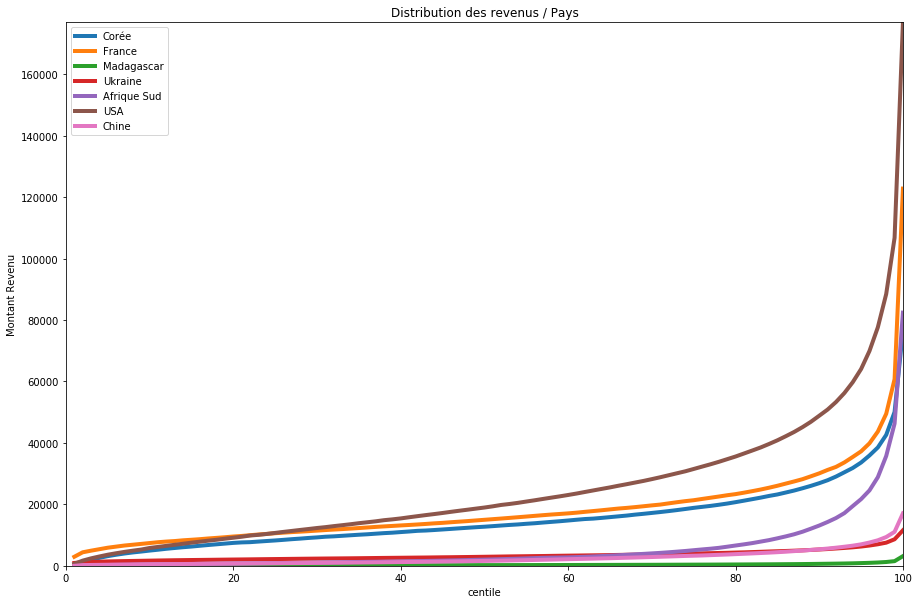

In [15]:
# Distribution des revenus / Pays choisi

inc1  = income2.loc[income2["country"] == 'KOR']
inc2  = income2.loc[income2["country"] == 'FRA']
inc3  = income2.loc[income2["country"] == 'MDG']
inc4  = income2.loc[income2["country"] == 'UKR']
inc5  = income2.loc[income2["country"] == 'ZAF']
inc6  = income2.loc[income2["country"] == 'USA']
inc10 = income2.loc[income2["country"] == 'CHN']

fig = plt.figure(figsize = (15, 10))
# plt.yscale('log')
plt.plot(inc1["quantile"], inc1["income"], label="Corée", linewidth=4)
plt.plot(inc2["quantile"], inc2["income"], label="France", linewidth=4)
plt.plot(inc3["quantile"], inc3["income"], label="Madagascar", linewidth=4)
plt.plot(inc4["quantile"], inc4["income"], label="Ukraine", linewidth=4)
plt.plot(inc5["quantile"], inc5["income"], label="Afrique Sud", linewidth=4)
plt.plot(inc6["quantile"], inc6["income"], label="USA", linewidth=4)
plt.plot(inc10["quantile"], inc10["income"], label="Chine", linewidth=4)


plt.legend(loc = 'upper left')
plt.title("Distribution des revenus / Pays")
plt.xlabel("centile")
plt.ylabel("Montant Revenu")
plt.xlim(0, 100)
plt.ylim(le_mini, le_maxi)
plt.show()

#### Echantillonner une population en utilisant des quantiles

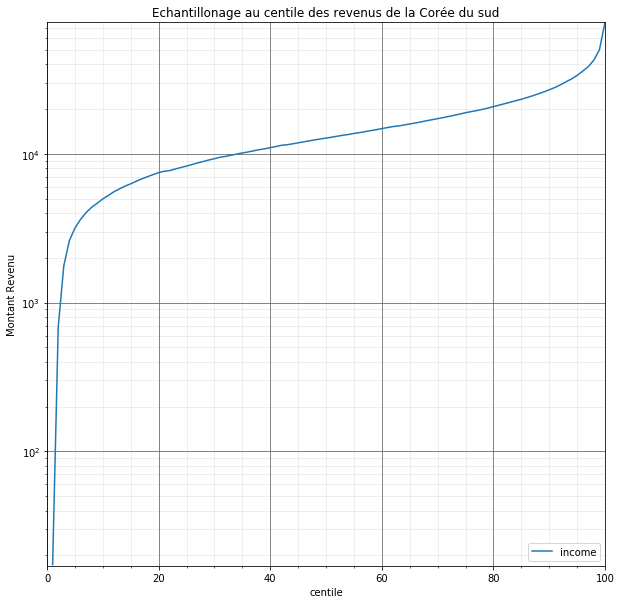

In [16]:
inc1  = income2.loc[income2["country"] == 'KOR']   # Corée du sud

fig = plt.figure(figsize = (10, 10))
plt.yscale('log')                                   # axe des ordonnées en échelle logarithmique
plt.plot(inc1["quantile"], inc1["income"])

plt.legend(loc = 'lower right')
plt.title("Echantillonage au centile des revenus de la Corée du sud")
plt.xlabel("centile")
plt.ylabel("Montant Revenu")
plt.xlim(0, 100)
plt.ylim(17, 76621)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

# Pour fixer les limites de l'axe des ordonnées
# print(income2.loc[income2["country"] == 'KOR'].loc[income2["quantile"] == 1])     # min = 17.317732
# print(income2.loc[income2["country"] == 'KOR'].loc[income2["quantile"] == 100])   # max = 76620.18


###  Courbe de Lorenz des pays choisis

Indice de Gini de KOR  :  36.79
Indice de Gini de ZAF  :  68.29
Indice de Gini de MDG  :  45.6
Indice de Gini de UKR  :  27.24
Indice de Gini de FRA  :  34.56
Indice de Gini de USA  :  44.73
Indice de Gini de CHN  :  49.33


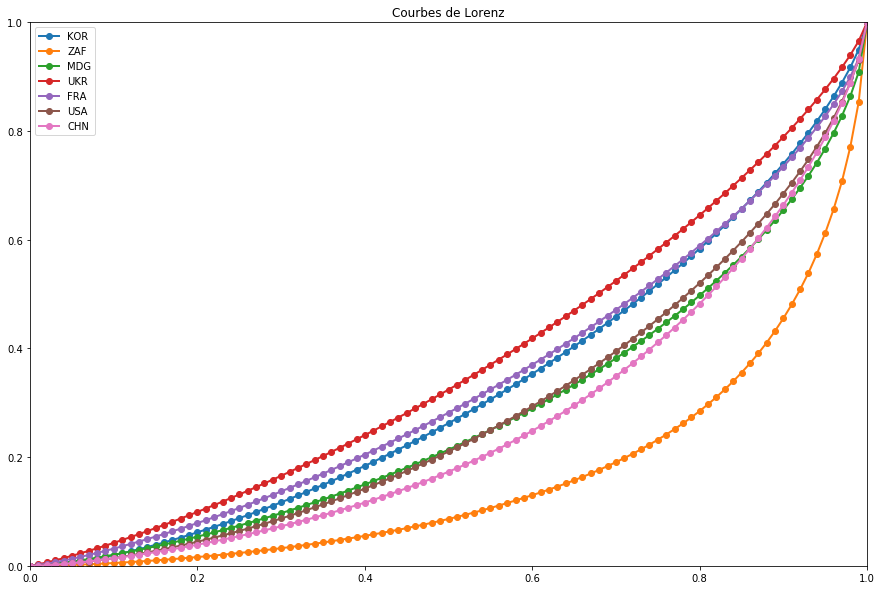

In [17]:
pays = ['KOR','ZAF','MDG','UKR','FRA','USA','CHN']

fig = plt.figure(figsize = (15, 10))

for p in pays:
    incomep = income2.loc[income2["country"] == p]
    cent_income = incomep['income'].values
    lorenz = np.cumsum(np.sort(cent_income)) / cent_income.sum()   # Trie des income ascendant
    lorenz = np.append([0],lorenz)                                 # La courbe de Lorenz commence à 0

    plt.plot(np.linspace(0,1,len(lorenz)), lorenz, "o-", label=p, linewidth=2)
    plt.axis([0,1,0,1])
    plt.title('Courbes de Lorenz')
    plt.legend(loc = 'upper left')
    
    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz)   # aire sous la courbe de Lorenz. 
                                                     # La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
    S = 0.5 - aire_ss_courbe                         # aire entre la 1e bissectrice et la courbe de Lorenz
    indice_gini = 2*S*100
    print("Indice de Gini de",p," : ", round(indice_gini,2))   # indice de Gini = 0.739
                                                               # Indice= 0   =>  égalité de répartition
                                                               # Indice= 100 =>  maximum de concentration 
plt.show()

### Evolution de l'indice de Gini

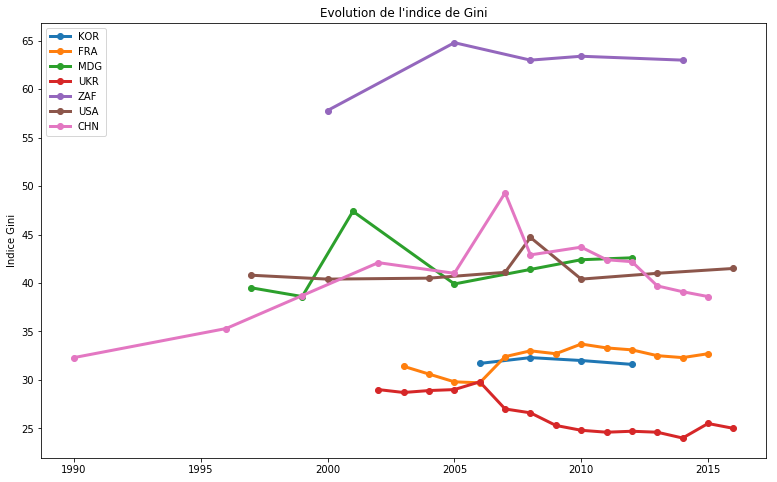

In [18]:
Gini_KOR = gini.loc[gini["Country Code"]== 'KOR']   # Corée du Sud = République de Corée
Gini_FRA = gini.loc[gini["Country Code"]== 'FRA']
Gini_MDG = gini.loc[gini["Country Code"]== 'MDG']
Gini_UKR = gini.loc[gini["Country Code"]== 'UKR']
Gini_ZAF = gini.loc[gini["Country Code"]== 'ZAF']
Gini_USA = gini.loc[gini["Country Code"]== 'USA']
Gini_CHN = gini.loc[gini["Country Code"]== 'CHN']


# Entrée: intervalle d'années
# Retour: dictionnaire {an:gini}
#
def gini_from_pays(first_year, last_year, gini_pays):
    dic= {}
    for year in np.arange(first_year, last_year+1, 1):
        column = year - 1960+2
        gini = gini_pays.iloc[0,column]
        if math.isnan(gini) is not True:
            dic[year] = gini_pays.iloc[0,column]
    return dic
  

dico_KOR = gini_from_pays(2006, 2012, Gini_KOR)
dico_FRA = gini_from_pays(2003, 2015, Gini_FRA)
dico_MDG = gini_from_pays(1997, 2017, Gini_MDG)
dico_UKR = gini_from_pays(1998, 2017, Gini_UKR)
dico_ZAF = gini_from_pays(2000, 2014, Gini_ZAF)
dico_USA = gini_from_pays(1997, 2016, Gini_USA)
dico_CHN = gini_from_pays(1990, 2015, Gini_CHN)


fig = plt.figure(figsize = (13, 8))
plt.plot(dico_KOR.keys(), dico_KOR.values(), "o-", label="KOR", linewidth=3)
plt.plot(dico_FRA.keys(), dico_FRA.values(), "o-", label="FRA", linewidth=3)
plt.plot(dico_MDG.keys(), dico_MDG.values(), "o-", label="MDG", linewidth=3)
plt.plot(dico_UKR.keys(), dico_UKR.values(), "o-", label="UKR", linewidth=3)
plt.plot(dico_ZAF.keys(), dico_ZAF.values(), "o-", label="ZAF", linewidth=3)
plt.plot(dico_USA.keys(), dico_USA.values(), "o-", label="USA", linewidth=3)
plt.plot(dico_CHN.keys(), dico_CHN.values(), "o-", label="CHN", linewidth=3)
plt.ylabel("Indice Gini")
plt.title('Evolution de l\'indice de Gini')
plt.legend(loc = 'upper left')
plt.show()

# Remarque :  Les indices sont plutôt stable avec le temps. C'est mieux ainsi pour la construction de notre modèle

### Classement des pays par indice de Gini

In [19]:
#   Classement des pays par indice de Gini  (pays avec revenus)

#  - moyenne
#  - les 5 pays ayant l'indice de Gini le plus élevé
#  - les 5 pays ayant l'indice de Gini le plus faible
#  - position de la France

gini_sort = gini.sort_values(by = '2008', ascending=True)
gini_sort = gini_sort[['Country Name', 'Country Code', '2008']]
gini_sort = gini_sort.reset_index()

# Moyenne de l'indice de Gini 
print("Moyenne Gini :", gini_sort['2008'].mean())

# position de la France
print("Position de la France :", gini_sort.loc[gini_sort["Country Code"]== 'FRA'].index[0] + 1)
gini_sort


Moyenne Gini : 37.79310344827586
Position de la France : 38


,index,Country Name,Country Code,2008
0,220,Slovenia,SVN,23.7
1,56,Denmark,DNK,25.2
2,219,Slovak Republic,SVK,26.0
3,52,Czech Republic,CZE,26.3
4,246,Ukraine,UKR,26.6
5,175,Norway,NOR,27.0
6,99,Hungary,HUN,27.5
7,212,Serbia,SRB,27.6
8,23,Belarus,BLR,27.8
9,73,Finland,FIN,27.8


# MISSION 3

### Affectation de chaque IGEincome (coef élasticité) à chaque pays

In [20]:
# Choix des coéfficients dans le fichier elasticity.
#                                                   Les valeurs de la colonne 'Base case' ont été retenu.

# Mobilité absolue  :  proportion de personnes dont le niveau de vie ou d’études est supérieur à celui de leurs parents.
# Mobilité relative :  dans quelle mesure la situation économique d’un individu ne dépend pas de celle de ses parents.
# Mobilité économique d’une génération à l’autre, est aussi appelée mobilité intergénérationnelle (MI).
# Dans une société à égalité de chances, le revenu du père n'a aucun rapport avec celui de son fils (corrélation = 0). 

# Notons au passage :
# - Les pays nordiques (Finlande, Norvège, Danemark) ont une plus grande égalité des chances - corrélations < 0,2. 
# - De nombreux pays en croissance, tels que le Brésil et la Chine, ont un score beaucoup plus élevé. 
# - À 0,47, les États-Unis se situent entre ces groupes, 
#     mais sa corrélation est toujours supérieure à celle de la plupart des autres pays de l’OCDE.


#                           | Base case  | Optimistic     | Pessimistic
# Nordic European countries |    0.2     |      0.15      |    0.3
#        and Canada
# Europe (except nordic     |    0.4     |      0.3       |    0.5
#         countries)        |            |                |
# Australia/New Zealand/USA |    0.4     |      0.3       |    0.5
# Asia                      |    0.5     |      0.4       |    0.6
# Latin America/Africa      |    0.66    |      0.5       |    0.9


# Les pays 'MNE','SRB','TLS','XKX' ont été rajoutés dans leur fichier respectif :
# Il manque 'MNE' (Monténégro)     dans le fichier Europe
# Il manque 'SRB' (Serbie)         dans le fichier Europe
# Il manque 'TLS' (Timor oriental) dans le fichier Asie
# Il manque 'XKX' (Kosovo)         dans le fichier Europe
#
#   Aide :  https://fr.wikipedia.org/wiki/Liste_des_codes_pays_du_CIO


# Les trigrammes de pays ont été récupérés dans le projet_3 (faim dans le monde - FAO). 
# Ils se répartissent dans autant de fichiers qu'il y a de continents.
# Format = [pays  iso  ige]
afrique_ige = pd.read_csv("afrique_ige.csv");   # afrique_iso.head(10)
americ_ige = pd.read_csv("americ_ige.csv");     # americ_iso.head(10)
asie_ige = pd.read_csv("asie_ige.csv");         # asie_iso.head(10)
europe_ige = pd.read_csv("europe_ige.csv")      # europe_iso.head(10)
oceanie_ige = pd.read_csv("oceanie_ige.csv")    # oceanie_iso.head(10)

# pays_ige contient maintenant le coef d'élasticité (IGEincome) de chaque pays, au choix  {0.2 ; 0.4 ; 0.5 ; 0.66}
pays_ige = pd.concat([afrique_ige, americ_ige, asie_ige, europe_ige, oceanie_ige])
pays_ige = pays_ige.reset_index(drop=True)

# Vérification que tous les pays ayant des revenus dans 'income', ont bien un coefficient d'élasticité
Pays_de_ige = pays_ige["iso"].unique()
income_sans_ige = [x for x in Pays_revenus if x not in Pays_de_ige]  
print("\nPays sans coefficient d'élasticité :", income_sans_ige)   

pays_ige.head(5)
# pays_ige.loc[pays_ige["iso"]== 'ARG'].iloc[0,2]   # TEST

pays_ige.loc[pays_ige["iso"]== 'ALB']   # TEST
# pays_ige


Pays sans coefficient d'élasticité : []


,pays,iso,ige
151,Albanie,ALB,0.4


In [21]:
# Option ige du fichier  'GDIMMay2018.csv'  pris en compte pour une analyse plus fine

ige_M = pd.read_csv("GDIMMay2018.csv") 
ige_M = ige_M[['iso3','IGEincome']]

print(len(ige_M))          # 6504
ige_M = ige_M.dropna()     # Suprimmer les lignes si au moins une colonne = NaN
ige_M = ige_M.drop_duplicates(subset=['iso3'], keep='first')
ige_M = ige_M.reset_index(drop=True)
print(len(ige_M))          # 75


Pays_de_ige_M = ige_M["iso3"].unique()
Pays_commun_ige = [x for x in Pays_de_ige_M if x in Pays_de_ige]  
print("\nPays en commun :", Pays_commun_ige,":   soit", len(Pays_commun_ige)," pays en commun.")
print(len(pays_ige))
print(len(Pays_de_ige_M),"\n")


# La valeur de 'ige' du dataframe 'pays_ige' sera remplacé par la valeur de 'IGEincome' du dataframe 'ige_M' pour les 
#    75 pays en commun, c'est à dire tous les pays de 'ige_M', car les valeurs sont plus fines.
for p in Pays_commun_ige:

    id_source = ige_M.loc[ige_M["iso3"]== p].index[0]          # index de la ligne à copier    : source
    igeIncome = ige_M.at[id_source, "IGEincome"]               # lecture de la valeur du coef
    id_cible  = pays_ige.loc[pays_ige["iso"]== p].index[0]     # index de la ligne à modifier  : cible
    pays_ige.at[id_cible, 'ige'] = igeIncome
    print("IGEincome remplacé par la valeur =", igeIncome ," pour le pays", p)
    
    
# On peut maintenant créer les tableaux de proba conditionnelles. Il y en a autant que de coef d'élasticité différents !!!
dic_pj = generate_pc_tab(pays_ige["ige"].unique())   # Temps d'execution = 313 secondes


6504
75

Pays en commun : ['ALB', 'AUS', 'AUT', 'BEL', 'BEN', 'BGD', 'BIH', 'BLR', 'BOL', 'BRA', 'CAN', 'CHE', 'CHL', 'CHN', 'COL', 'CYP', 'CZE', 'DEU', 'DNK', 'ECU', 'EGY', 'ESP', 'ETH', 'FIN', 'FRA', 'GBR', 'GHA', 'GIN', 'GRC', 'GTM', 'HRV', 'IND', 'IRL', 'ITA', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR', 'LUX', 'LVA', 'MAR', 'MDG', 'MKD', 'MLI', 'MNG', 'MWI', 'MYS', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PRT', 'ROU', 'RUS', 'RWA', 'SGP', 'SVK', 'SVN', 'SWE', 'TLS', 'TUN', 'TWN', 'TZA', 'UGA', 'USA', 'UZB', 'VNM', 'ZAF', 'COD'] :   soit 75  pays en commun.
212
75 

IGEincome remplacé par la valeur = 0.8158745  pour le pays ALB
IGEincome remplacé par la valeur = 0.275  pour le pays AUS
IGEincome remplacé par la valeur = 0.24526679999999998  pour le pays AUT
IGEincome remplacé par la valeur = 0.183176  pour le pays BEL
IGEincome remplacé par la valeur = 0.8551162  pour le pays BEN
IGEincome remplacé par la valeur = 0.5379999999999999  pour le pays BGD
IGEincome remplacé

### Ajout de la colonne coefficient d'élasticité = 'ige'

In [24]:
# TESTS
p_ige = pays_ige[['iso','ige']]
p_ige.columns = ['country', 'ige']
income2 = pd.merge(income2, p_ige)   # merge sur la colonne 'country'

### Ajout de la classe parent

In [25]:
# IMPORTANT :
#
#  Faire la distinction entre les questions qui traitent ou pas de la classe_parent :
#  - Celles qui en parlent, utilisent income3  (=income2*1000)
#  - les autres questions utilisent income2


# Décompte du temps que prend l'ajout du quantile parent
start_time = time.time()
print("\n\nTemps d\'execution estimé pour l'ajout de la classe parent: 45 secondes\n")


# len(income2)   # = 11600  
income3 = income2.copy()
    
# Dupliquer 1000 fois chaque ligne du dataframe
income3 = pd.concat([income3]*1000, ignore_index=True)    # 1000 pour que çà marche avec le calcul des classes parents
# print("len(income3) =", len(income3))   #  11600000

# Maintenant chaque centile existe en 1000 exemplaires et représente une Classe enfant pour un pays.
# Il faut attribuer aux 1000 individus leurs classes Parent conformément aux proba-conditionnelles calculée auparavant 
#   et qui tiennent compte du coef d'élasticité de chaque pays = IGEincome (relative IGM in income)



# --------  AJOUT de la CLASSE PARENT

# Trie de income3 sur  'country' et 'quantile'
income3 = income3.sort_values(by = ['country','quantile'])
income3.reset_index(drop = True, inplace = True)

pays = income3.country.unique()   # 116 pays



nb_quantiles   = 100
nb_quantiles_p = 100
list_qp = []           # liste des quantiles parents
s1 = pd.Series()   # Series à ajouter, comme une colonne, à income3 en fin de boucle FOR

for p in pays:   # traitement de chaque pays dans le même ordre que income3 et seulement ceux d'income3

    IGEincome = pays_ige.loc[pays_ige["iso"]== p].iloc[0,2]   # Récupére l'IGEincome d'1 pays : coef elasticité
    # print("IGEincome =", IGEincome, "  pour le pays : ", p)

    cd = dic_pj.get(IGEincome)

    # Parcours des quantiles de 1 à 100 pour un pays
    #          Pour chaque quantile, création de 1000 quantiles parents en respectant les proba-conditionelles de cd
    #               Ex: Pour le quantile 1, on récupère les proba-condi de la 1ere ligne du tableau cd
    
    for q in np.arange(0, nb_quantiles):     # de 0 à 99, afin de parcourir les indices du tableau cd (= quantile enfant)
        # print("ENFANT N°", q)
 
        ligne = cd[q]      # UNE ligne, donc un quantile enfant,  parmi 100 autres lignes de 100 proba-conditionelles
        for q_p in np.arange(0, nb_quantiles_p):     # de 0 à 99, afin de parcourir les indices d'une ligne du tableau cd
            #print("  Parent _", q_p)
            multi = ligne[q_p]         # ce n'est pas une proba, mais le nombre de parents à insérer avec le quantile q_p+1
        
            if multi == 0:
                # print("Pas de Parent ", q_p, "pour ce quantile enfant", q)
                continue         # On ajoute rien à la list car ce couple enfant_q/parent_q_p  a une proba de zéro
                
            clp = q_p+1              # classe parent 'clp' à insérer multi fois. (+1 car l'index commence à zéro)
            list_qe = [clp for i in range(int(multi))]    # crée une liste multi element= clp
            list_qp += list_qe
                


s1 = pd.Series(list_qp)     # Création d'une series à partir de la liste list_qp constituée plus haut
income3['classe_p'] = s1    # Ajout de la series s1 à income3

print("Temps d\'execution : %s secondes ---" % (time.time() - start_time))   # Affichage du temps d execution



Temps d'execution estimé pour l'ajout de la classe parent: 45 secondes

Temps d'execution : 46.476686000823975 secondes ---


In [24]:
#   RAPPEL :

#   Pour UN pays, chaque quantile existe en 1000 examplaires identiques dans income.
#   Il faut attribuer à ces 1000 examplaires du même quantile enfant, un quantile parent.
#
#   A chaque exemplaire est attribué un quantile parent en s'aidant du CD (tableau de Proba. Condi.) correspondant au pays.
#   Ex : Pour le quantile enfant '1' , je balaye les 100 colonnes de le la 1ere ligne du tableau CD.
#        La cellule CD[0][O] représente le quantile parent '1' et sa probabilité d'apparaitre avec le quantile enfant '1'
#        Si cette proba=0 alors on passe à CD[0][1]. Si la proba>0 alors on l'a multiplie par 1000.
#        proba*1000 sera le nombre de quantile(s) parent 2  attribué(s) au quantile enfant 1.
    
#   Au bout du compte on aura bien 1000 quantile-enfant=1 associés à différents quantile-parents si la probabilité > 0
#      du couple enfant-parent
#   exemple :
#              Quantile-enfant   Quantile-parent
#                     1                 1
#                     1                 3
#                     1                 3
#                     1                 4
#                     1                 8
#                     1                 8
#                     1                 8
#   ...
#   ...
#   ...
#                     1                 98
#   ...               2                 9
#   ...               2                 9
#   etc


### Suppression des Outliers



Temps d'execution estimé pour la suppression des Outliers : 201 secondes

Taille d'incomeNoOutlier2SD = 11182
Taille d'incomeNoOutlier3SD = 11182000
Temps d'execution : 156.24840235710144 secondes ---


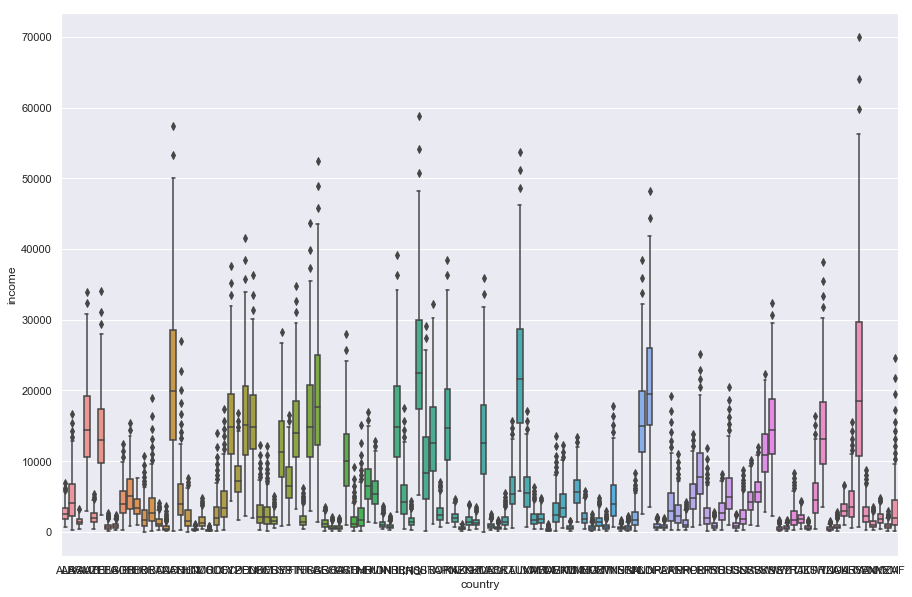

In [25]:
# ######  Création d'une version des données sans Outliers :

print("\n\nTemps d\'execution estimé pour la suppression des Outliers : 201 secondes\n")
start_time = time.time()



# TEST => option non retenue
# # ----------------------------------------------------------------------------------
# # Suppression des pays suivants jugés trop influents :    Option radicale car elle supprime complètement les pays suivants
# # 
# # Voir plus loin dans le code, le calcul des points de levier
# Pays_influent = ['BRA', 'CAF', 'COL', 'GTM', 'HND', 'IRL', 'LUX', 'NOR', 'USA', 'ZAF']
# income2NoInfluent = income2[~income2.country.isin(Pays_influent)]
# income3NoInfluent = income3[~income3.country.isin(Pays_influent)]



# ----------------------------------------------------------------------------------
# Suppression des centiles en tenant compte du fait que les log_income suivent une loi normale.
# 
# ecart type (= standard deviation = SD)
#
# Selon l'article de Wikipedia sur la distribution normale, 
#  - environ 68% des valeurs tirées d'une distribution normale se situent dans les limites d'un écart-type σ de la moyenne
#  - environ 95% des valeurs se situent dans les limites de deux écarts types
#  - environ 99,7% se situent dans les trois écarts types
# 
# Choix de supprimer toutes les valeurs (income ou log_income) au-delà de la Moyenne +ou- 2/3fois l'écart-type
#
# Ces valeurs rendent les échelles de nos graphiques irréalistes.
#
MSD=2   # 2 ou 3 fois l'écart-type
incomeNoOutlier2SD = pd.DataFrame()
for p in Pays_revenus:
    incp = income2.loc[income2["country"] == p]
    mean = np.mean(incp["income"],  axis=0)
    sd   = np.std(incp["income"], axis=0)
    incp = incp.loc[incp["income"] > mean - MSD*sd]
    incp = incp.loc[incp["income"] < mean + MSD*sd]
    incomeNoOutlier2SD = pd.concat([incomeNoOutlier2SD, incp])
incomeNoOutlier2SD = incomeNoOutlier2SD.reset_index(drop=True)
print("Taille d'incomeNoOutlier2SD =", len(incomeNoOutlier2SD))   # 11182


incomeNoOutlier3SD = pd.DataFrame()
for p in Pays_revenus:
    incp = income3.loc[income3["country"] == p]
    mean = np.mean(incp["income"],  axis=0)
    sd   = np.std(incp["income"], axis=0)
    incp = incp.loc[incp["income"] > mean - MSD*sd]
    incp = incp.loc[incp["income"] < mean + MSD*sd]
    incomeNoOutlier3SD = pd.concat([incomeNoOutlier3SD, incp])
incomeNoOutlier3SD = incomeNoOutlier3SD.reset_index(drop=True)
print("Taille d'incomeNoOutlier3SD =", len(incomeNoOutlier3SD))   # 11182000

# --- Tous les pays ---
figure = plt.figure(figsize = (15, 10))
sns.set()
ax = sns.boxplot(x="country", y="income", data=incomeNoOutlier2SD)



print("Temps d\'execution : %s secondes ---" % (time.time() - start_time))

##    CHOIX des DONNEES pour la REGRESSION

In [26]:
# Choix des données pour les régressions SANS la classe parent :   Ne garder qu'une assignation !
income2X = income2
# income2X = incomeNoOutlier2SD    # sans Outlier au-delà de 2*ecart-type/moyenne


# Choix des données pour les régressions AVEC la classe parent :   Ne garder qu'une assignation !
income3X = income3
# income3X = incomeNoOutlier3SD    # sans Outlier au-delà de 2*ecart-type/moyenne

In [27]:
# TEST
# print(incomeNoOutlier2SD.head(5))
# print(incomeNoOutlier3SD.head(5))
print(income2X.head(5)); print("Taille de income2X", len(income2X))
print(income3X.head(5)); print("Taille de income3X", len(income3X))

  country  year_survey  quantile  nb_quantiles      income  gdpppp  gini       ige
0     ALB         2008         1           100   728.89795  7297.0  30.0  0.815874
1     ALB         2008         2           100   916.66235  7297.0  30.0  0.815874
2     ALB         2008         3           100  1010.91600  7297.0  30.0  0.815874
3     ALB         2008         4           100  1086.90780  7297.0  30.0  0.815874
4     ALB         2008         5           100  1132.69970  7297.0  30.0  0.815874
Taille de income2X 11600
  country  year_survey  quantile  nb_quantiles     income  gdpppp  gini       ige  classe_p
0     ALB         2008         1           100  728.89795  7297.0  30.0  0.815874         1
1     ALB         2008         1           100  728.89795  7297.0  30.0  0.815874         1
2     ALB         2008         1           100  728.89795  7297.0  30.0  0.815874         1
3     ALB         2008         1           100  728.89795  7297.0  30.0  0.815874         1
4     ALB        

### Ajout des colonnes 'log_income', 'log_gdpppp' et 'log_mean' 

In [28]:
income2X['log_income'] = np.log(income2X['income'])
income2X['log_gdpppp'] = np.log(income2X['gdpppp'])

income3X['log_income'] = np.log(income3X['income'])
income3X['log_gdpppp'] = np.log(income3X['gdpppp'])

In [29]:
# TEST
# print(incomeNoOutlier2SD.head(5))
# print(incomeNoOutlier3SD.head(5))
print(income2X.head(5)); print("Taille de income2X", len(income2X))
print(income3X.head(5)); print("Taille de income3X", len(income3X))

  country  year_survey  quantile  nb_quantiles      income  gdpppp  gini       ige  log_income  log_gdpppp
0     ALB         2008         1           100   728.89795  7297.0  30.0  0.815874    6.591534    8.895219
1     ALB         2008         2           100   916.66235  7297.0  30.0  0.815874    6.820739    8.895219
2     ALB         2008         3           100  1010.91600  7297.0  30.0  0.815874    6.918612    8.895219
3     ALB         2008         4           100  1086.90780  7297.0  30.0  0.815874    6.991092    8.895219
4     ALB         2008         5           100  1132.69970  7297.0  30.0  0.815874    7.032359    8.895219
Taille de income2X 11600
  country  year_survey  quantile  nb_quantiles     income  gdpppp  gini       ige  classe_p  log_income  log_gdpppp
0     ALB         2008         1           100  728.89795  7297.0  30.0  0.815874         1    6.591534    8.895219
1     ALB         2008         1           100  728.89795  7297.0  30.0  0.815874         1    6.5915

## Conditions d'application de l'ANOVA :  Tests préliminaires

### - Normalité des données

### - Egalité des variances

### - Multicolinéarité

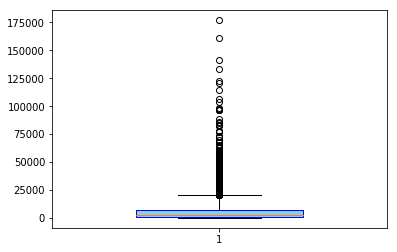

<Figure size 432x288 with 0 Axes>

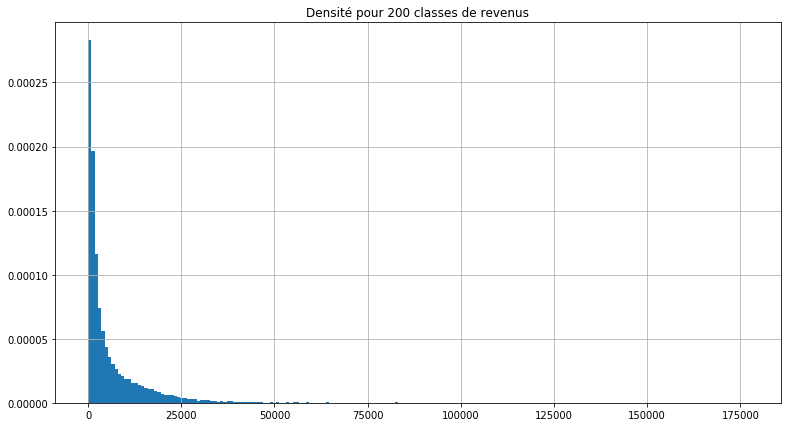

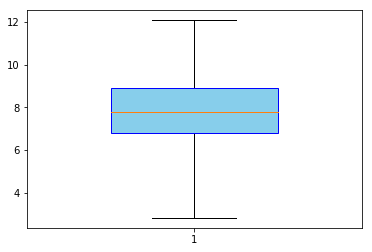

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


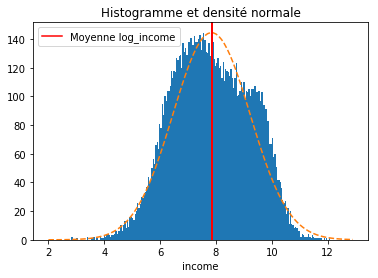

Min = 2.8165707984382817
Max = 12.083501257741979
Moyenne =  7.84061914941141
Ecart-type =  1.3811208987009722


count     11600.000000
mean       6069.121925
std        9413.786596
min          16.719418
25%         900.768508
50%        2403.492950
75%        7515.313700
max      176928.550000
Name: income, dtype: float64

<Figure size 432x288 with 0 Axes>

In [30]:

# ------------------- income -------------------
# Boite à moustaches
# plt.ylim(16, 176929)
bp = plt.boxplot([income2X["income"]],  patch_artist = True, whis = 2, widths = [0.5])
for patch in bp['boxes']:
  patch.set_color('skyblue')
  patch.set_edgecolor('blue')
plt.show()

# Histogramme
fig = plt.figure(1)
fig = plt.figure(figsize = (13, 7))
income2X["income"].hist(density=True,bins=200)
plt.title("Densité pour 200 classes de revenus")
plt.show()

# Analyse :  L'histogramme comme la boite montre clairement que la distribution des 'income' ne suit pas une loi normale.



# ------------------- log_income -------------------
# Boite à moustaches
# plt.ylim(16, 176929)
bp = plt.boxplot(np.log(income2X["income"]),  patch_artist = True, whis = 2, widths = [0.5])
for patch in bp['boxes']:
  patch.set_color('skyblue')
  patch.set_edgecolor('blue')
plt.show()

# Histogramme
fig, ax = plt.subplots()
n, bins, patches = ax.hist(np.log(income2X['income']), normed=False, bins=(200))    # affiche l'histogramme -> 200 classes

bins=np.arange(2, 13, 0.1)                                 # Les abcisses
income_std = np.std(np.log(income2X['income']), ddof=1)     # écart-type
income_moy = np.mean(np.log(income2X['income']))            # moyenne

y = mlab.normpdf(bins, income_moy, income_std)*500   # calcule chacun des elts de la courbe gausienne
# --> Pour obtenir la probabilité des bins sachant que (moyenne= income_moy  &  écart-type= income_std)

ax.plot(bins, y, '--')       # trace la courbe
ax.set_xlabel('income')
ax.set_title("Histogramme et densité normale")

plt.axvline(income_moy, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne log_income")])  # légende
plt.show()

print("Min =",min(np.log(income2X['income'])))   # 2.8165707984382817
print("Max =",max(np.log(income2X['income'])))   # 12.083501257741979
print("Moyenne = ",income_moy)                  # 7.84061914941141
print("Ecart-type = ",income_std)               # 1.3811208987009722
plt.savefig("Histogramme et densité normale")

#  La fonction de densité (en pointillée) permet d'apprécier le rapprochement entre la distribution empirique (histogramme) 
#     et la distribution théorique (la courbe).
# Analyse :  L'histogramme comme la boite montre une distribution des 'log_income' à l'allure Gausienne.
#              Des tests statistiques doivent valider cette hypothèse.


income2X.income.describe()

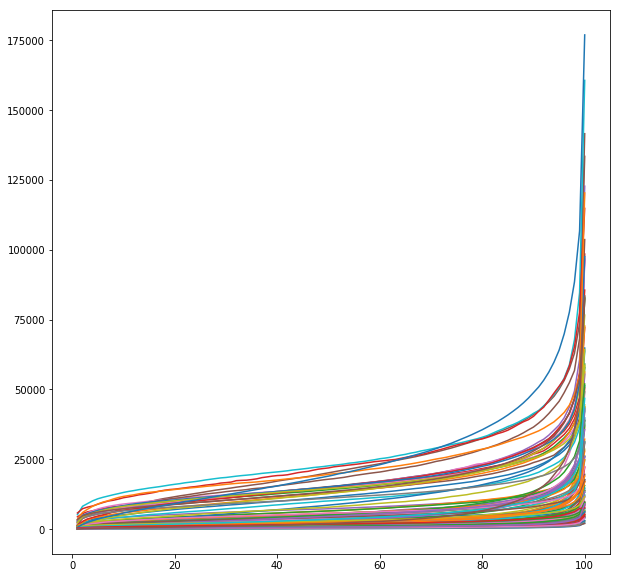

In [31]:
# Représention des incomes pour tous les Pays

fig = plt.figure(figsize = (10, 10))
# plt.yscale('log')                                   # axe des ordonnées en échelle logarithmique
for p in income2X.country.unique():
    incPaysX  = income2X.loc[income2X["country"] == p]
    plt.plot(incPaysX["quantile"], incPaysX["income"])
plt.show()

# income2X.describe()
# Moyenne income = 6069


###  Tests de Normalité

In [32]:
#  Test de Shapiro-Wilk     (adéquation à une loi normale)
#
#    [L’hypothèse nulle (H0) de ces tests est : " L’échantillon suit une loi normale“.  (p_value > 5%)
#                                 
# - La pvalue s'avère imprécise pour un effectif > 5000
print("                statistique       , p-value")
print("income     :  ",st.shapiro(income2X["income"]))
print("log_income :  ",st.shapiro(income2X["log_income"]))
# income     :   (0.5987708568572998, 0.0                     => pas normale
# log_income :   (0.9917128682136536, 2.309867560882171e-25   => pas normale
  

# Test de Kolmogorov-Smirnov     (adéquation à une loi normale)
#
# Le test étudie l'écart entre la fonction de répartition d'une loi normale et celle estimée de notre échantillon 
# Plus cette quantité est grande, plus on est enclin à rejeter l'hypothèse comme quoi l'échantillon est gaussien.
#  H0:  F=F0
print("\n")
print("income     :  ",ks_2samp(income2X["income"],list(np.random.normal(np.mean(income2X["income"]), np.std(income2X["income"]), 1000))))
print("log_income :  ",ks_2samp(income2X["log_income"],list(np.random.normal(np.mean(income2X["log_income"]), np.std(income2X["log_income"]), 1000))))
# income     :   Ks_2sampResult(statistic=0.281, pvalue=4.405833404668959e-64)
# log_income :   Ks_2sampResult(statistic=0.04863793103448277, pvalue=0.02476761091582868)    => Loi normale


                statistique       , p-value
income     :   (0.5987708568572998, 0.0)
log_income :   (0.9917128682136536, 2.309867560882171e-25)


income     :   Ks_2sampResult(statistic=0.229, pvalue=1.0568091137338597e-42)
log_income :   Ks_2sampResult(statistic=0.04501724137931029, pvalue=0.0464786081497231)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#      MISSION 4

## ANOVA

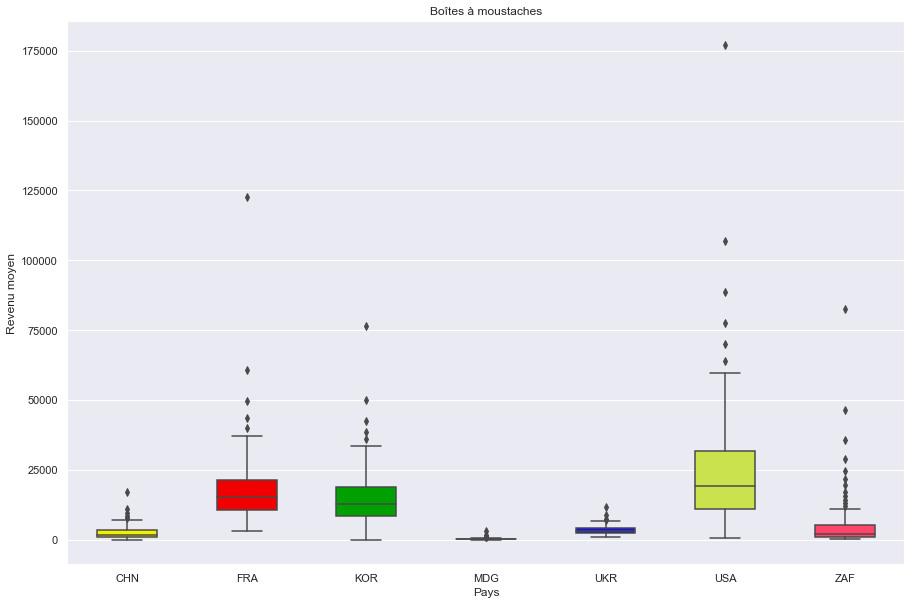

<Figure size 432x288 with 0 Axes>

In [43]:
#        1.a   ANOVA

X = "country"   # Variable explicative
Y = "income"    # Variable expliquée qualitative

# --- 7 pays choisis ---
Pays_choisi = ['KOR','ZAF','MDG','FRA','USA','UKR','CHN']
inc = income2X.loc[income2X["country"].isin(Pays_choisi)]

modalites = inc[X].unique()
groupes = []
for m in modalites:
    groupes.append(inc[inc[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

# La boite à moustaches montre la distribution des revenus pour chacune des modalités de la variable Pays.



# --- 7 pays choisis (autre version) ---
Pays_choisi = ['KOR','ZAF','MDG','FRA','USA','UKR','CHN']
pays = income2X.loc[income2X["country"].isin(Pays_choisi)]

figure = plt.figure(figsize = (15, 10))
sns.set()

# sns.boxplot(x="country", y="income", data=pays, color='white')     # même couleur pour tous les pays 
bplot = sns.boxplot(x="country", y="income", data=pays, width=0.5)   # couleurs standards spécifiée par Seaborn
plt.xlabel('Pays')
plt.ylabel('Revenu moyen')
plt.title('Boîtes à moustaches')

pays_colors=["#F0F000","#F00000","#00A000","#00A0F0","#1010F0","#C9E24D","#FF456A"]
color_dict = dict(zip(Pays_choisi, pays_colors))   # dictionnaire de couleurs avec le pays comme clé
for i in range(0,7):        # 7 pays
    mybox = bplot.artists[i]
    mybox.set_facecolor(color_dict[Pays_choisi[i]])
plt.show()
plt.savefig('lolo')

# Analyse :  
#           Les diagrammes en boîtes sont souvent asymétriques, avec des médianes non centrées,
#                des médianes différentes de la moyenne et un nombre relativement élevé de valeurs aberrantes.
#   Donc on peut emettre une réserve que cette distribution soit une distribution normale.
#
# Amélioration :  éliminer les outliers
# Les extrémités des moustaches sont délimités par 1.5 fois l'intervalle inter-quartile (Q3−Q1) au maximum. 
#   Cela permet de déceler l'existence de point extrême au-delà des moustâches.



# --- Tous les pays ---
figure = plt.figure(figsize = (15, 10))
sns.set()
ax = sns.boxplot(x="country", y="income", data=income2X)
plt.xlabel('Pays')
plt.ylabel('Revenu moyen')
plt.title('Boîtes à moustaches')

# Analyse :  
#           peu lisible mais on voit que beaucoup de pays ont des valeurs extrèmes



# ---------------------------------------------------------
# def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

print("R2 (SCE/SCT) = ", eta_squared(inc[X],inc[Y]))   # R2 = 0.3455305779832616

# C'est le "rapport de corrélation", compris entre 0 et 1 :
#       0  , cela signifie que les moyennes par classes sont toutes égales
#       1  , cela signifie que les moyennes par classes sont très différentes

# trait       -> médiane
# point rouge -> moyenne
          

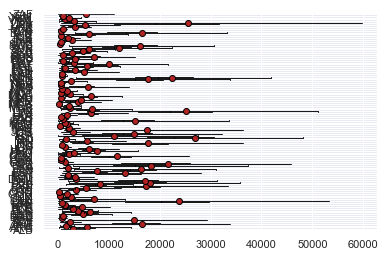

R2 (SCE/SCT) =  0.4963901423109968


In [36]:
#        1.b   ANOVA

X = "country"
Y = "income"

modalites = income2X[X].unique()
groupes = []
for m in modalites:
    groupes.append(income2X[income2X[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()


# ---------------------------------------------------------
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print("R2 (SCE/SCT) = ", eta_squared(income2X[X],income2X[Y]))   # R2 = 0.4963901423109968


# - Le coefficient de détermination (R2) est égal à 0.4963, ce qui indique que 49.63 % de la variation des revenus
#    s'expliquent par le pays lui-même
# - 50.37 % de la variation des revenus est expliqué par d'autres facteurs

# La dispersion factorielle est du même ordre de grandeur que la disepersion résiduelle,
#     cela signifie que les moyennes de revenus ne sont pas globalement différentes selon les pays.


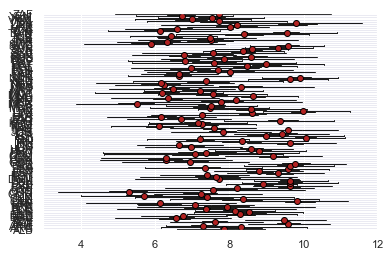

R2 (SCE/SCT) =  0.7292381117731965


In [37]:
#        1.c   ANOVA     Transformation semi-logarithmique (car appliquée seulement à la variable à expliquer)

X = "country"
Y = "log_income"

modalites = income2X[X].unique()
groupes = []
for m in modalites:
    groupes.append(income2X[income2X[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

# ---------------------------------------------------------
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print("R2 (SCE/SCT) = ", eta_squared(income2X[X],income2X[Y]))   # R2 = 0.7292

# - Le coefficient de détermination (R2) est égal à 0.7292, ce qui indique que 72.92 % de la variation des revenus
#    s'expliquent par le pays lui-même
# - 27.08 % de la variation des revenus est expliqué par d'autres facteurs


In [38]:
#        3.   ANOVA  /  Variable explicative -> PAYS


anova = smf.ols('income~country', data=income2X).fit()   # Calcul des moindres carrés
print(anova.summary())   # tableau d'analyse de la variance
print("\n\n")
print(sm.stats.anova_lm(anova, typ=2))   # Type 2 ANOVA 

# (R-squared = 0.496) => la dispersion factorielle est du même ordre de grandeur que la dispersion résiduelle
#                            ,cela signifie que les moyennes d'income ne sont pas globalement différentes d'un pays à l'autre.




# Le test de Fisher nous donne une p-valeur de 0.00 < 5%.  On rejette donc l'hypothèse H0 selon laquelle la moyenne des incomes est 
# équivalente d'un pays à l'autre.
# La pays a donc bien un effet sur l'income, comme semblaient l'indiquer les boîtes à moustaches.



                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     98.43
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:44:07   Log-Likelihood:            -1.1862e+05
No. Observations:               11600   AIC:                         2.375e+05
Df Residuals:                   11484   BIC:                         2.383e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2994.8299    671.390      4.

                sum_sq       df          F  PR(>F)
country   5.102375e+11    115.0  98.429271     0.0
Residual  5.176586e+11  11484.0        NaN     NaN


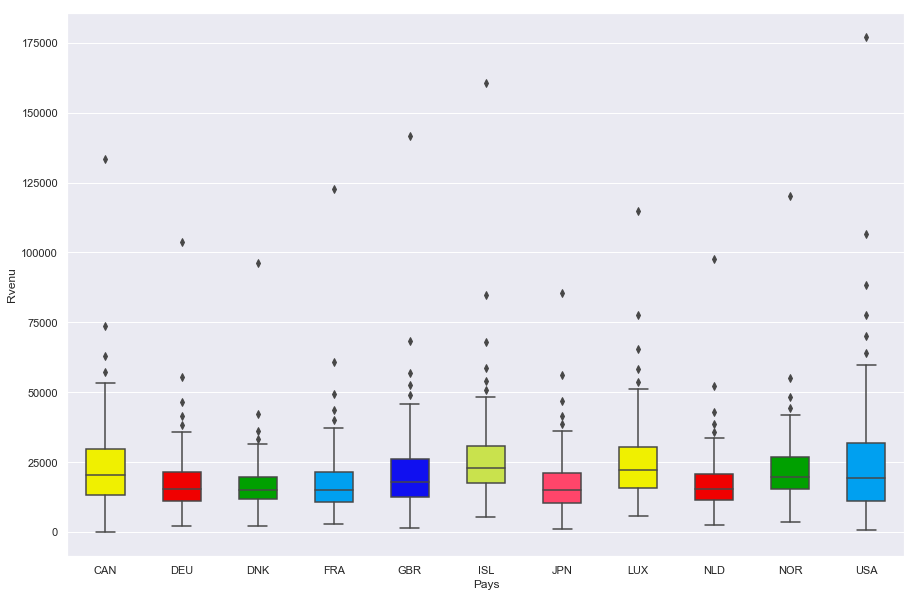

Text(0,0.5,'Revenu')

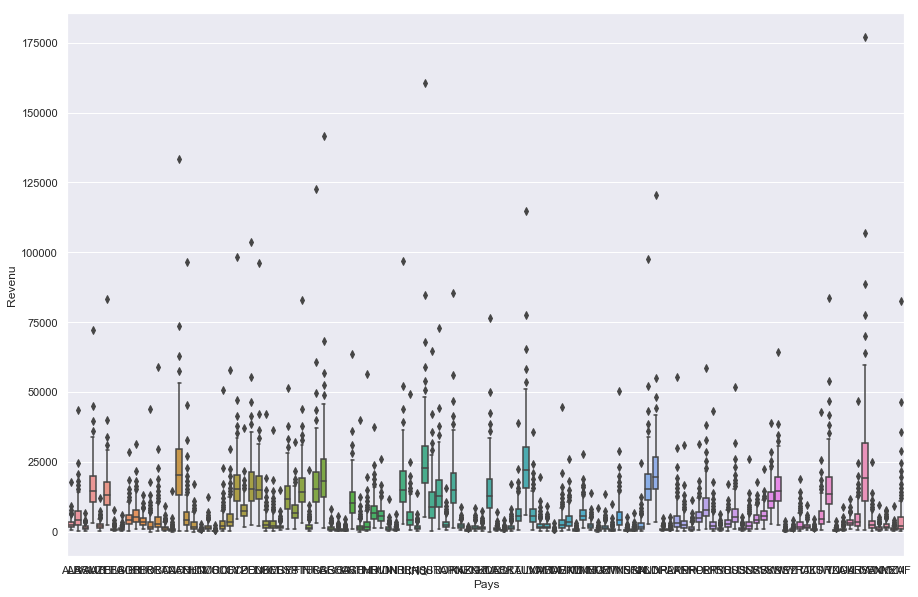

In [39]:

Pays_choisi = ['USA','CAN','ISL','GBR','LUX','NOR','JPN','DEU','FRA','NLD','DNK']
pays = income2X.loc[income2X["country"].isin(Pays_choisi)]

# Plante si pas 'influent  10 278 961‬

figure = plt.figure(figsize = (15, 10))
sns.set()

bplot = sns.boxplot(x="country", y="income", data=pays, width=0.5)   # couleurs standards spécifiée par Seaborn
plt.xlabel('Pays')
plt.ylabel('Rvenu')
# plt.title('Boîtes à moustaches')

pays_colors=["#F0F000","#F00000","#00A000","#00A0F0","#1010F0","#C9E24D","#FF456A","#F0F000","#F00000","#00A000","#00A0F0"]
color_dict = dict(zip(Pays_choisi, pays_colors))   # dictionnaire de couleurs avec le pays comme clé
for i in range(0,11):        # 11 pays
    mybox = bplot.artists[i]
    mybox.set_facecolor(color_dict[Pays_choisi[i]])
plt.show()


# Tous les pays :
figure = plt.figure(figsize = (15, 10))
sns.set()
ax = sns.boxplot(x="country", y="income", data=income2X)
plt.xlabel('Pays')
plt.ylabel('Revenu')

# On étudie ici l'influence du pays sur le revenu.
# On visualise cette influence en affichant ces boîtes à moustaches :



Temps d'execution estimé pour cette cellule ->  2 secondes



                             OLS Regression Results                            
Dep. Variable:         np.log(income)   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     269.0
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:44:21   Log-Likelihood:                -12627.
No. Observations:               11600   AIC:                         2.549e+04
Df Residuals:                   11484   BIC:                         2.634e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


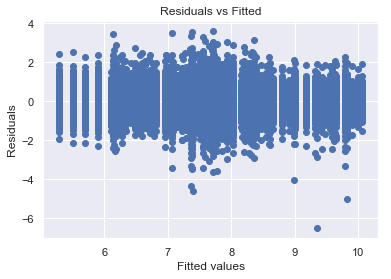

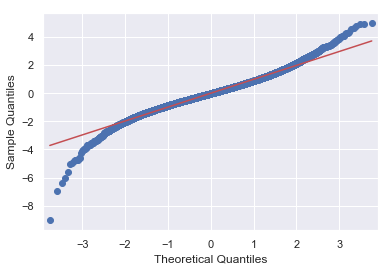

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro - Normalité des résidus  :   (0.9785935878753662, 2.529312619280387e-38) 



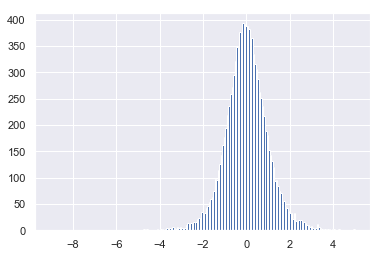

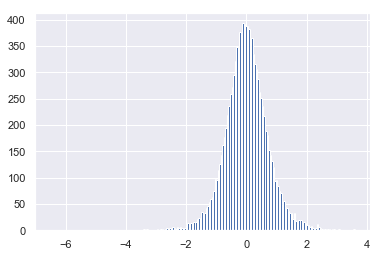


Temps d'execution : 1.9655160903930664 secondes ---


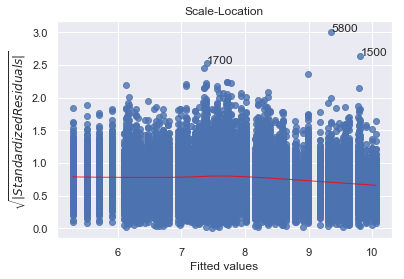

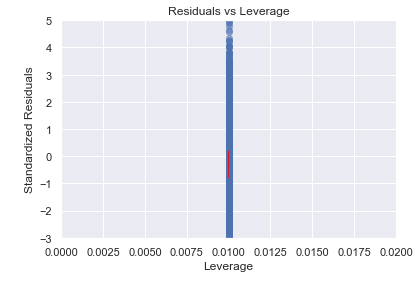

In [40]:
# Décompte du temps que prend l'execution de cette cellule
start_time = time.time()
print("\n\nTemps d\'execution estimé pour cette cellule ->  2 secondes\n")


anova = smf.ols('np.log(income)~country', data=income2X).fit()   # LOIC
print("\n\n",anova.summary())
print("\n")
print(sm.stats.anova_lm(anova, typ=2))

model_fitted_y = anova.fittedvalues                                       # model values
model_residuals = anova.resid                                             # model residuals
model_norm_residuals = anova.get_influence().resid_studentized_internal   # normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))     # absolute squared normalized residuals
model_abs_resid = np.abs(model_residuals)                                 # absolute residuals
model_leverage = anova.get_influence().hat_matrix_diag                    # leverage, from statsmodels internals
model_cooks = anova.get_influence().cooks_distance[0]                     # cook's distance, from statsmodels internals
mnr = pd.Series(model_norm_residuals)



# 1. Indépendance des résidus :   Residuals vs Fitted -
#
plot_lm_1 = plt.figure()
plt.scatter(model_fitted_y, model_residuals)
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
plot_lm_1.show()
plt.show()
plot_lm_1.savefig("Residuals vs Fitted")


# 2. Normalité des résidus :   Normal Q-Q ---
# 
graphics.gofplots.qqplot(model_norm_residuals, line='r')
plt.show()
plt.savefig("Normal Q-Q")   

print("Shapiro - Normalité des résidus  :  ",st.shapiro(model_residuals),"\n")

# Histogram of normalized residuals
mnr.mean()   # = 1.452317193709483e-14
mnr = mnr.sort_values()
mnr.hist(bins=200)
plt.show()
model_residuals.mean()   # = 1.452317193709483e-14
model_residuals = model_residuals.sort_values()
model_residuals.hist(bins=200)
plt.show()


# 3. Homogénéité des variances :   Scale-Location ---
#
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.8);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
plot_lm_3.savefig("Scale-Location") 


# 4. Residuals vs Leverage ---
#
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False, ci=False, lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
plot_lm_4.savefig("Residuals vs Leverage") 


print("\nTemps d\'execution : %s secondes ---" % (time.time() - start_time))



# Le test de Fisher nous donne une p-valeur de 0.00 < 5%.  On rejette donc l'hypothèse H0 selon laquelle la moyenne des incomes 
# est équivalente d'un pays à l'autre.
# La pays a donc bien un effet sur l'income, comme semblaient l'indiquer les boîtes à moustaches.

# (R2 = 0.729) => la dispersion factorielle est du même ordre de grandeur que la dispersion résiduelle
#                            ,cela signifie que les moyennes d'income ne sont pas globalement différentes d'un pays à l'autre.
# country    5.102375e+11    115.0  98.429271  0.000000
# Residual   5.176586e+11  11484.0        NaN       NaN
# R-squared = 5.102375e+11/(5.102375e+11+5.176586e+11) = 0.496

# Le coefficient de détermination R²=0.729, juge de la qualité de la régression linéaire simple.
# Ici l'equation de la droite de régression est capable de déterminer 72.9 % de la distribution des points.


In [41]:
#             HYPOTHESES pour la REGRESSION

# La régression est une technique paramétrique qui repose donc sur des hypothèses. Les voici :
    
# 1. Il existe une relation linéaire et additive entre les variables dépendantes (DV) et indépendantes (IV). 
#    - Par linéaire, cela signifie que le changement de DV par 1 unité de changement dans IV est constant.
#    - Par additif, il se réfère à l'effet de X sur Y est indépendant d'autres variables.

# 2. Il ne doit y avoir aucune CORRELATION entre les variables indépendantes. 
#    La présence de corrélation dans les variables indépendantes conduit à la MULTICOLINEARITE. 
#    Si les variables sont corrélées, 
#       il devient extrêmement difficile pour le modèle de déterminer le véritable effet des VI sur la VD.
#    => Matrice de corrélation.  gdpppp avec income !!!

# 3. Les résidus doivent avoir une variance constante. L'absence de variance constante conduit à une HETEROSCEDASTICITE.

# 4. Les termes d'erreur ne doivent pas être corrélés, c'est-à-dire qu'une erreur en t ne doit pas indiquer une erreur en t + 1. 
#    La présence de corrélation en termes d'erreur est connue sous le nom d'AUTOCORRELATION. 
#    Cela affecte considérablement les coefficients de régression et les valeurs d'erreur standard,
#        car ils sont basés sur l'hypothèse de termes d'erreur non corrélés.

# 5. La variable dépendante et les résidus doivent suivre une distribution normale.


#    ! La performance d'un modèle de régression est conditionnée à la réalisation de ces hypothèses !

# # -------------------------------------------------------------------------------------------------------------------------

# 3. Durbin Watson Statistique (DW) - Ce test mesure l'AUTOCORRELATION (résidus non indépendants => HETEROSCEDASTICITE)

#    DW = [0;4]
#    DW = 2 =>  aucune autocorrélation
#    0<DW<2 =>  autocorrélation positive
#    2<DW<4 =>  autocorrélation négative
#    1<DW<2 =>  autocorrélation admise
#    dw = statsmodels.stats.stattools.durbin_watson(anova.resid)

# 2. Facteur d’inflation (VIF) - Cette métrique teste la MULTICOLINEARITE. 
#    VIF<=4  =>  aucune multicolinéarité
#    VIF>=10 =>  suggère une multicolinéarité élevée. 
#    La valeur de tolérance (1/VIF) détermine la corrélation dans les VI.   
#    Vous pouvez également créer une matrice de corrélation pour déterminer les variables colinéaires.

# 3. Breusch-Pagan / Cook Weisberg Test - Ce test determine la présence d'HETEROSCEDASTICITE. 
#    Si vous trouvez p_value <0,05, vous rejetez l'hypothèse nulle et induisez que l'hétéroscédasticité est présente.



SyntaxError: invalid syntax (<ipython-input-41-01aff3a68329>, line 3)

In [41]:
# MULTICOLINEARITE :
    
# Ceci est une préoccupation majeure lors de la réalisation de régressions linéaires. 
# Une façon de vérifier la multicolinéarité consiste à exécuter une matrice de corrélation sur les données ou,
#   à vérifier les facteurs d'inflation de la variance (VIF). 

# S'il existe de fortes corrélations entre les variables VI, ou un facteur VIF élevé, 
#   vous pouvez supprimer l'une des variables ou effectuer une régression de Shapley ou une régression de Ridge?
#      qui prend en compte les variables hautement corrélées.

# La corrélation entre les exogènes, et de manière plus générale la colinéarité, fausse l’inférence statistique, 
#    notamment parce qu’elle gonfle la variance estimée des coefficients. 
# L’analyse de la matrice des corrélations est une des techniques de détection.
# Matrice des corrélations : Une règle simple de vérification est de calculer les corrélations croisées entre exogènes
#     et de comparer leur valeur absolue avec 0.8.


# Le problème de multicollinéarité perturbe l’inférence statistique, en partie parce qu’il gonfle la l'erreur standard estimée 
# des coefs. Utilisons quelques techniques de détection basées sur l’analyse de la matrice de corrélation dans cette section.
mat_co2 = income2X[['gini','gdpppp']]
print("Matrice de Corrélation2 :"); print(mat_co2.corr())
print("\n")
#             gini    gdpppp
# gini    1.000000 -0.371525
# gdpppp -0.371525  1.000000
mat_co3 = income3X[['gini','gdpppp','classe_p']]
print("Matrice de Corrélation3 :"); print(mat_co3.corr())
print("\n")
#                   gini        gdpppp      classe_p
# gini      1.000000e+00 -3.715252e-01  6.228218e-17
# gdpppp   -3.715252e-01  1.000000e+00 -1.396493e-16
# classe_p  6.228218e-17 -1.396493e-16  1.000000e+00
# En règle général on compare la valeur absolue de la corrélation entre chaque paire de variables avec la valeur de seuil 0.8
# Il y a une faible corrélation négative entre gdpppp et gini : -0.371525


#Klein’s rule of thumb
mc = scipy.corrcoef(mat_co3,rowvar=0)
mc2 = mc**2
print("\nMC2 :", mc2)
# [[1.00000000e+00 1.38030991e-01 1.95625620e-34]
#  [1.38030991e-01 1.00000000e+00 3.86327945e-35]
#  [1.95625620e-34 3.86327945e-35 1.00000000e+00]]
# Aucune des valeurs n’excède le R²(=0.448)
# Il n'y a donc pas de risque de multicolinéarité, comme semblait l'indiquer le warning du tableau de résultats de régression


# Facteur d’inflation de la variance (VIF):   évalue la liaison d’une exogène avec l’ensemble des autres variables.
#
# . On dépasse la simple corrélation ici. On le lit sur la diagonale de l’inverse de la matrice de corrélation
vif = np.linalg.inv(mc)   
print("\nVIF :", vif)
# [[ 1.16013452e+00  4.31019234e-01 -1.35473516e-17]
#  [ 4.31019234e-01  1.16013452e+00  1.18234567e-18]
#  [-1.35473516e-17  1.18234567e-18  1.00000000e+00]]
# Une variable pose problème dès lors que VIF > 4.  Ce n'est pas le cas ici ...
#                                                                        ->  1.16013452e+00 : 1.16013452e+00 : 1.00000000e+00

#     
# autocorrélation :
#     En statistique, l'autocorrélation d'une série temporelle discrète ou d'un processus Xt,
#       est simplement la corrélation du processus par rapport à une version décalée dans le temps de lui-même.
    
# corrélation :  ajustement d’une variable par rapport à l’autre par une relation affine obtenue par régression linéaire

# multicolinéarité :  On parle de multicolinéarité parfaite lorsqu’une des variables explicatives d’un modèle,
#           est une combinaison linéraire d’une ou plusieurs autres variables explicatives introduites dans le même modèle.
#  La multicolinéarité n’a aucune incidence sur l’adéquation de l’ajustement, ni sur la qualité de la prévision. 
#  Cependant, les coefficients individuels associés à chaque variable explicative,
#         ne peuvent pas être interprétés de façon fiable.

# Ne pas confondre MULTICOLINEARITE et CORRELATION. 
# Si des variables colinéaires sont de facto fortement corrélées entre elles, 
#    deux variables corrélées ne sont pas forcément colinéaires. 
# En termes non statistiques, il y a colinéarité lorsque deux ou plusieurs variables mesurent la même chose.
# Est-ce que 'gdpppp' et 'income' ne mesure pas la même chose ?  (Hum, oui, sauf que 'income' n'est pas une VI)

# http://larmarange.github.io/analyse-R/multicolinearite.html

# Avec mes termes, la MULTICOLINEARITE, c'est lorsque vous voulez mesurer l'influence de la var1 et de la var2, 
#   mais qu'elles sont toutes deux présentes ou toutes deux absentes. Vous ne pouvez pas mesurez l'influence de l'une seule.
# Appliqué à notre projet, çà veut dire qu'une var. 'gdpppp' par exemple, va épouser les fluctuations de 'income'
# 

Matrice de Corrélation2 :
            gini    gdpppp
gini    1.000000 -0.371525
gdpppp -0.371525  1.000000


Matrice de Corrélation3 :
                  gini        gdpppp      classe_p
gini      1.000000e+00 -3.715252e-01  5.999366e-17
gdpppp   -3.715252e-01  1.000000e+00  4.611472e-17
classe_p  5.999366e-17  4.611472e-17  1.000000e+00



MC2 : [[1.00000000e+00 1.38030991e-01 1.61797129e-34]
 [1.38030991e-01 1.00000000e+00 1.05688179e-34]
 [1.61797129e-34 1.05688179e-34 1.00000000e+00]]

VIF : [[ 1.16013452e+00  4.31019234e-01  1.03257703e-17]
 [ 4.31019234e-01  1.16013452e+00 -6.44419151e-18]
 [ 1.03257703e-17 -6.44419151e-18  1.00000000e+00]]


## Régression Linéaire Multiple



Temps d'execution estimé pour cette cellule ->  19 secondes

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     4699.
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:03:48   Log-Likelihood:            -1.1916e+05
No. Observations:               11600   AIC:                         2.383e+05
Df Residuals:                   11597   BIC:                         2.383e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


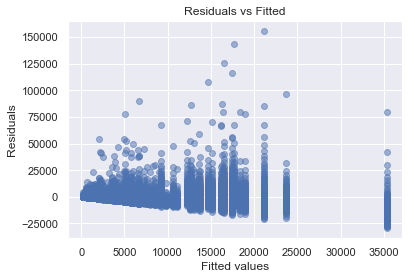

Durbin Watson Statistique : 0.6254931927588745
Test de Breusch-Pagan / Cook Weisberg : (289.49596312989405, 1.3700939219771155e-63, 148.41445940310282, 2.2671968362858244e-64)


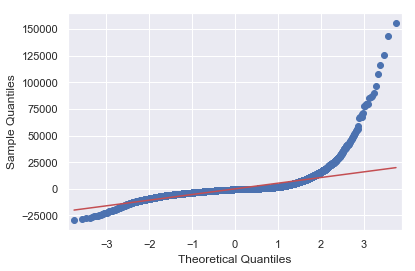

Shapiro - Normalité des résidus  :   (0.5748730897903442, 0.0) 

Kolmogorov-Smirnov :   Ks_2sampResult(statistic=0.2714482758620689, pvalue=7.908982722733021e-60)

the statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt
3809713.2566029215 / 0.0 / 6.547214712842646 / 90.8105988847847


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Test de Breusch-Pagan / Cook Weisberg : (289.49596312989405, 1.3700939219771155e-63, 148.41445940310282, 2.2671968362858244e-64)

Temps d'execution : 1.161057710647583 secondes ---


<Figure size 432x288 with 0 Axes>

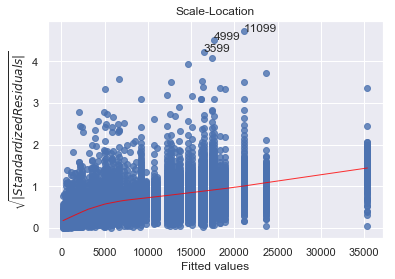

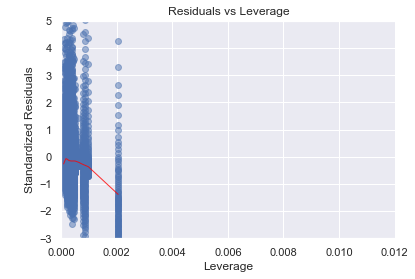

In [44]:
#
#        REGRESSION avec les Variables explicatives :  - gdpppp
#                                                      - Gini

# Décompte du temps que prend l'execution de cette cellule
start_time = time.time()
print("\n\nTemps d\'execution estimé pour cette cellule ->  19 secondes\n")


regr = smf.ols('income~gdpppp+gini', data=income2X).fit()   # LOIC
print(regr.summary())
print("\n\n")
print(sm.stats.anova_lm(regr, typ=3))

# Pour la décomposition de la variance
# interc   = sm.stats.anova_lm(regr, typ=3).sum_sq[0]
gdpppp   = sm.stats.anova_lm(regr, typ=3).sum_sq[1]
gini     = sm.stats.anova_lm(regr, typ=3).sum_sq[2]
residual = sm.stats.anova_lm(regr, typ=3).sum_sq[3]
Total    = gdpppp + gini + residual   # + interc
# var_interc   = round((interc/Total)*100,2)
var_gdpppp   = round((gdpppp/Total)*100,2)
var_gini     = round((gini/Total)*100,2)
var_residual = round((residual/Total)*100,2)
print("\n")
# print("%Variance interc   =", var_interc,"%")
print("%Variance gdpppp   =", var_gdpppp,"%")
print("%Variance gini     =", var_gini,"%")
print("%Variance residual =", var_residual,"%")
# Si tu additionnes tes variances expliquées (donc sans les résidus), 
#   tu dois retrouver ton R2( 0.448).  Cela te permet de t'autocontrôler.

#                 sum_sq       df            F    PR(>F)
# Intercept  1.238369e+08      1.0     2.529513  0.111762
# gdpppp     4.026758e+11      1.0  8225.125081  0.000000
# gini       1.739993e+08      1.0     3.554141  0.059422
# Residual   5.677519e+11  11597.0          NaN       NaN
# %Variance gdpppp   = 41.49 %
# %Variance gini     = 0.02 %
# %Variance residual = 58.49 %


model_fitted_y = regr.fittedvalues                                       # model values
model_residuals = regr.resid                                             # model residuals
model_norm_residuals = regr.get_influence().resid_studentized_internal   # normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))    # absolute squared normalized residuals
model_abs_resid = np.abs(model_residuals)                                # absolute residuals
model_leverage = regr.get_influence().hat_matrix_diag                    # leverage, from statsmodels internals
model_cooks = regr.get_influence().cooks_distance[0]                     # cook's distance, from statsmodels internals



# 1. Indépendance des résidus :   Residuals vs Fitted --- (Résidus vs Prédites)
#
plot_lm_1 = plt.figure()
plt.scatter(model_fitted_y, model_residuals, alpha=0.5);   
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
plot_lm_1.show()
plt.show()
plot_lm_1.savefig("Residuals vs Fitted")
# forme d'entonnoir (KO) 
#       => cela suggère que vos données souffrent d'hétéroscédasticité (les termes d'erreur ont une variance non constante).
# motif visible => data non linéaire

# Durbin Watson Statistique (DW) - Ce test mesure l'AUTOCORRELATION (résidus non indépendants => HETEROSCEDASTICITE)
dw = statsmodels.stats.stattools.durbin_watson(model_residuals)
print("Durbin Watson Statistique :", dw)   # = 0.6254931927588745  - 0<DW<2 =>  autocorrélation positive
# Si dw=2 alors les résidus ne sont pas corrélés et sont indépendants.  hétéroscédasticité

# HETEROSCEDASTICITE :  Ceci peut être testé en utilisant le graphique "residual vs. fitted values ", 
#   (si une forme de cône est présente, une hétéroscédasticité est présente), 
#     ou en utilisant un test statistique tel que le test de Bruesch-Pagan :
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (289.49596312989405, 1.3700939219771155e-63, 148.41445940310282, 2.2671968362858244e-64)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.
# On peut modifier le(s) variable(s) pour améliorer le modèle

# 2. Normalité des résidus :    Normal Q-Q ---
# 
#  nous confrontons la distribution empirique des résidus avec la distribution théorique de la loi normale
# L’inférence dans la régression linéaire multiple (MCO) repose sur l’hypothèse de normalité des erreurs. 
# L’hypothèse nulle (normalité) est rejetée si la série de points s’écarte manifestement de la diagonale
sm.qqplot(model_residuals, line='r')
plt.show()
plt.savefig("Normal Q-Q")   
# ligne courbée et déformée => les résidus ont une distribution non normale

print("Shapiro - Normalité des résidus  :  ",st.shapiro(model_residuals),"\n")
# Shapiro - Normalité des résidus  :   (0.5748730897903442, 0.0) => pas normale
# Si le test est significatif, la distribution ne suit pas une loi normale.  (p_value < 5%)

# Test de Kolmogorov-Smirnov     (adéquation à une loi normale)
# Le test étudie l'écart entre la fonction de répartition d'une loi normale et celle estimée de notre échantillon 
# Plus cette quantité est grande, plus on est enclin à rejeter l'hypothèse comme quoi l'échantillon est gaussien.
#  H0:  F=F0
print("Kolmogorov-Smirnov :  ",ks_2samp(model_residuals, list(np.random.normal(np.mean(model_residuals), np.std(model_residuals), 1000))))
# (statistic=0.23241379310344823, pvalue=5.67702183339604e-44) => pas normale

# Jarque-Bera - Normalité des résidus
#   Ce test vérifie si l'asymétrie et le kurtosis observés correspondent à une distribution normale.
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(model_residuals)
print("\nthe statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt")
print(JB,"/",JBpv,"/",skw,"/",kurt)
# 3809713.2566029215 / 0.0 / 6.547214712842646 / 90.8105988847847
# Ici, on peut supposer que les erreurs suivent une distribution normale au niveau de 5%.
# On attend un skewness (mesure d'asymétrie)     proche de 0 => symétrie
# On attend un kurtosis (mesure d'aplatissement) proche de 0 => même aplatissement que la distribution normale
# On en est loin !




# 3. Homogénéité des variances :   Scale-Location ---
#
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.8);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
plot_lm_3.savefig("Scale-Location") 
# Ce graphique est également utile pour déterminer l'hétéroscédasticité. 
# Idéalement, ce graphique ne doit montrer aucun motif. La présence d'un motif détermine l'hétéroscédasticité. 
# Ce graphique corobbore la forme de l'entonnoir dans Residuals vs Fitted
# La ligne doit être +OU- horizontale

# Test de Breusch-Pagan / Cook Weisberg - Ce test determine la présence d'HETEROSCEDASTICITE
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (289.49596312989405, 1.3700939219771155e-63, 148.41445940310282, 2.2671968362858244e-64)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.


# 4. Residuals vs Leverage ---
#
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False, ci=False, lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
plot_lm_4.savefig("Residuals vs Leverage") 



print("\nTemps d\'execution : %s secondes ---" % (time.time() - start_time))



# L'ajustement du modèle est moyen, avec un R² = 0.448, est globalement significatif à 5% [F-statistic = 4699, avec
# Prob(F-statistic) = 0.00]. 
# Pour les paramètres estimés, seule la variable GDPPPP est pertinente pertinentes à 5%.
# Avertissement : peut être un problème de colinéarité entre les exogènes.
    
# On peut regarder les effets de chaque VI sur la VD (coef VI) et voir s’il s’agit ou non d’un prédicteur significatif (P>|z|).
# On veut une p_value <0,05. Tous les VI sont des prédicteurs significatifs des revenus, à l’exception de gini. 
# Donc gini n'a pas d'importance dans ce contexte.

# Le coefficient (coef) peut être interprété comme étant l'effet d'un changement d'unité en termes de VD. 
# Ce qui signifie que pour chaque augmentation d'une unité de l'VI, la DV augmentera ou diminuera de la valeur du coefficient.

# Passons en revue l'équation de régression linéaire pour voir comment ces données constituent un modèle explicatif. 
# Explicatif lorsqu'il est utilisé pour expliquer l'influence de chaque VI.
#      income = -576.0182 + 0.4847*(gdpppp)

# Une analyse de régression multiple a été utilisée pour déterminer si le GDPPPP et l'indice de Gini,
#  prédisaient de manière significative l'income.
# Les résultats de la régression indiquent que les 3 prédicteurs expliquent 44,8% de la variance (R2 = 0,448).
# income = -576.0182 + 0.4847*(gdpppp) + 16.1552*(gini)
# Toutes les variables indépendantes utilisées dans le modèle sont des prédicteurs significatifs de income, 
#      à l’exception du gini.
# En effet, on constate ici que pour gini le paramètre n'est pas significativement différents de 0, 
#  car sa p-valeur(5.9%) n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.
# C'est le cas aussi pour intercept


p_value test Breusch Pagan: 1.3700939219771155e-63


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


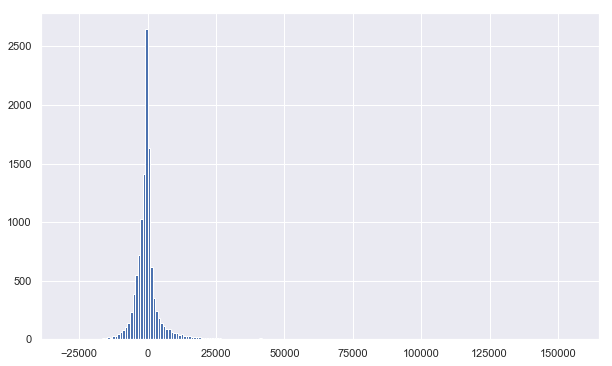

In [73]:
#  Colinéarité des variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = regr.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
# [1.1601345168822024, 1.1601345168822021]
# Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.


#  Test de l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regr.resid, variables)
print('p_value test Breusch Pagan:', pval)
# p_value test Breusch Pagan: 1.3700939219771155e-63
# p-valeur < 5%, on rejette l'hypothèse H0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).


# Normalité des résidus
st.shapiro(regr.resid)
# (0.5748730897903442, 0.0)
# Ici, l'hypothèse de normalité est remise en cause (p-value = 0.0 < 0.05).
# Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, 
#  et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que,
#     les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, 
#       même si le résidu n'est pas considéré comme étant gaussien.

# Histogram of normalized residuals
plt.figure(figsize=(10,6))
regr.resid.hist(bins=200)
plt.show()

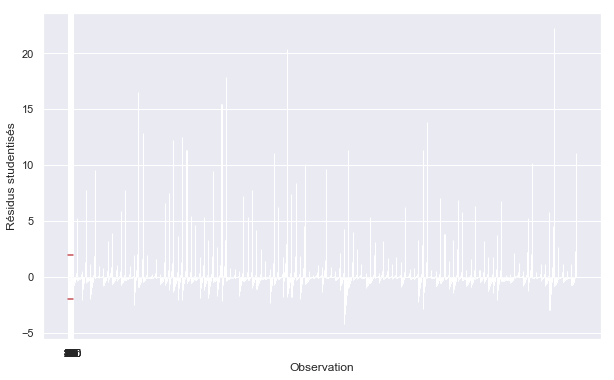

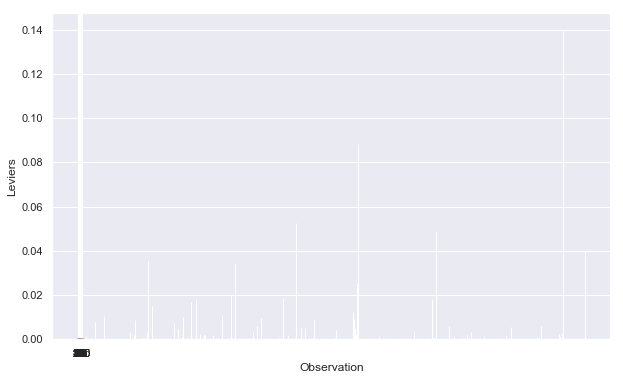

In [45]:
#  TESTS

alpha = 0.05
n = income2X.shape[0]   # n, le nombre d'individus de l'échantillon
p = 2                   # p, le nombre de variables

# Analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé 'analyses'
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

# calcul des leviers, en sachant que le seuil des leviers est de = 2∗p/n
analyses['levier'] = regr.get_influence().hat_matrix_diag
# print(len(analyses['levier']))   # 11600 -> c'est le nombre d'observations qui rend les bars blanches
seuil_levier = 2*p/n

plt.figure(figsize=(500,100))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 115], [seuil_levier, seuil_levier], color='r')
plt.show()


# Selection des points pour lesquels le levier est supérieur au seuil :
analyses.loc[analyses['levier'] > seuil_levier, :]

# Calcul des résidus studentisés
analyses['rstudent'] = regr.get_influence().resid_studentized_internal
seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1)

plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 115], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 115], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()


# Distance de Cook
influence = regr.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

# détecter les observations influentes :
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 115], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [46]:
# Colinéarité

mat_co2 = income2X[['income','gini','gdpppp']]
print("Matrice de Corrélation sur income2 :")
print(mat_co2.corr())

mat_co3 = income3X[['income','gini','gdpppp','classe_p']]
print("\nMatrice de Corrélation sur income3 :")
print(mat_co3.corr())
# 'income' et 'mean' sont fortement corrélé , c'est normal.


Matrice de Corrélation sur income2 :
          income      gini    gdpppp
income  1.000000 -0.236450  0.668945
gini   -0.236450  1.000000 -0.371525
gdpppp  0.668945 -0.371525  1.000000

Matrice de Corrélation sur income3 :
            income          gini        gdpppp      classe_p
income    1.000000 -2.364504e-01  6.689447e-01  1.566812e-01
gini     -0.236450  1.000000e+00 -3.715252e-01  5.999366e-17
gdpppp    0.668945 -3.715252e-01  1.000000e+00  4.611472e-17
classe_p  0.156681  5.999366e-17  4.611472e-17  1.000000e+00




Temps d'execution estimé pour cette cellule ->  19 secondes

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 1.092e+04
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:05:44   Log-Likelihood:                -14063.
No. Observations:               11600   AIC:                         2.813e+04
Df Residuals:                   11597   BIC:                         2.815e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


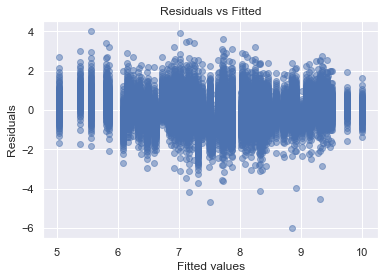

Durbin Watson Statistique : 0.30405565819318126
Test de Breusch-Pagan / Cook Weisberg : (566.5935814605449, 9.242022999125912e-124, 297.76777519756007, 7.799322040841137e-127)


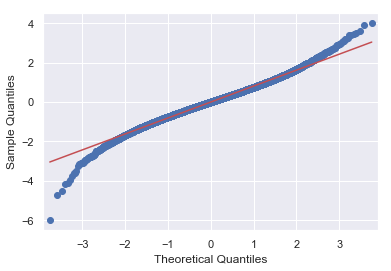

Shapiro - Normalité des résidus  :   (0.9903228878974915, 2.738748647744447e-27) 

Kolmogorov-Smirnov :   Ks_2sampResult(statistic=0.04967241379310339, pvalue=0.020506681795753323)

the statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt
1045.4508313486385 / 9.621359052260488e-228 / -0.08795324036191764 / 4.460157056645285


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Test de Breusch-Pagan / Cook Weisberg : (566.5935814605449, 9.242022999125912e-124, 297.76777519756007, 7.799322040841137e-127)

Temps d'execution : 1.0750293731689453 secondes ---


<Figure size 432x288 with 0 Axes>

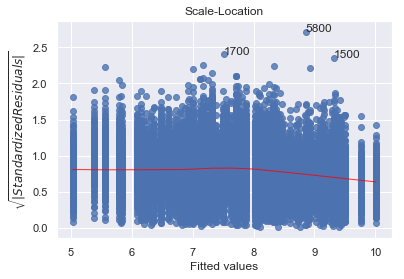

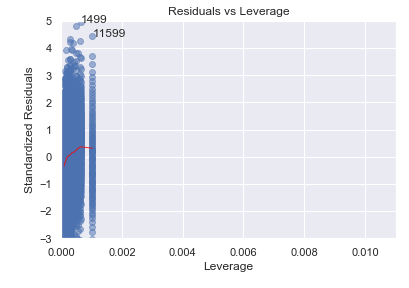

In [47]:
#
#        REGRESSION avec les Variables explicatives :  - log_gdpppp
#                                                      - gini       


# Décompte du temps que prend l'execution de cette cellule
start_time = time.time()
print("\n\nTemps d\'execution estimé pour cette cellule ->  19 secondes\n")


regr = smf.ols('log_income~log_gdpppp+gini', data=income2X).fit()   # LOIC
print(regr.summary())
print("\n\n")
print(sm.stats.anova_lm(regr, typ=3))

# Pour la décomposition de la variance
log_gdpppp = sm.stats.anova_lm(regr, typ=3).sum_sq[1]
gini       = sm.stats.anova_lm(regr, typ=3).sum_sq[2]
residual   = sm.stats.anova_lm(regr, typ=3).sum_sq[3]
Total      = log_gdpppp + gini + residual
var_log_gdpppp = round((log_gdpppp/Total)*100,2)
var_gini       = round((gini/Total)*100,2)
var_residual   = round((residual/Total)*100,2)
print("\n%Variance log_gdpppp =", var_log_gdpppp,"%")
print("%Variance gini         =", var_gini,"%")
print("%Variance residual     =", var_residual,"%")


model_fitted_y = regr.fittedvalues                                       # model values
model_residuals = regr.resid                                             # model residuals
model_norm_residuals = regr.get_influence().resid_studentized_internal   # normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))     # absolute squared normalized residuals
model_abs_resid = np.abs(model_residuals)                                 # absolute residuals
model_leverage = regr.get_influence().hat_matrix_diag                    # leverage, from statsmodels internals
model_cooks = regr.get_influence().cooks_distance[0]                     # cook's distance, from statsmodels internals



# 1. Indépendance des résidus :   Residuals vs Fitted --- (Résidus vs Prédites)
#
plot_lm_1 = plt.figure()
plt.scatter(model_fitted_y, model_residuals, alpha=0.5);   
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
plot_lm_1.show()
plt.show()
plot_lm_1.savefig("Residuals vs Fitted")
# forme d'entonnoir (KO) 
#       => cela suggère que vos données souffrent d'hétéroscédasticité (les termes d'erreur ont une variance non constante).
# motif visible => data non linéaire

# Durbin Watson Statistique (DW) - Ce test mesure l'AUTOCORRELATION (résidus non indépendants => HETEROSCEDASTICITE)
dw = statsmodels.stats.stattools.durbin_watson(model_residuals)
print("Durbin Watson Statistique :", dw)   # = 0.30405565819318126  - 0<DW<2 =>  autocorrélation positive
# Si dw=2 alors les résidus ne sont pas corrélés et sont indépendants.

# HETEROSCEDASTICITE :  Ceci peut être testé en utilisant le graphique "residual vs. fitted values ", 
#   (si une forme de cône est présente, une hétéroscédasticité est présente), 
#     ou en utilisant un test statistique tel que le test de Bruesch-Pagan :
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (566.5935814605449, 9.242022999125912e-124, 297.76777519756007, 7.799322040841137e-127)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.
# On peut modifier le(s) variable(s) pour améliorer le modèle

# 2. Normalité des résidus :    Normal Q-Q ---
# 
#  nous confrontons la distribution empirique des résidus avec la distribution théorique de la loi normale
# L’inférence dans la régression linéaire multiple (MCO) repose sur l’hypothèse de normalité des erreurs. 
# L’hypothèse nulle (normalité) est rejetée si la série de points s’écarte manifestement de la diagonale
sm.qqplot(model_residuals, line='r')
plt.show()
plt.savefig("Normal Q-Q")   
# ligne courbée et déformée => les résidus ont une distribution non normale

print("Shapiro - Normalité des résidus  :  ",st.shapiro(model_residuals),"\n")
# Shapiro - Normalité des résidus  :   (0.9903228878974915, 2.738748647744447e-27) => pas normale
# Si le test est significatif, la distribution ne suit pas une loi normale.  (p_value < 5%)

# Test de Kolmogorov-Smirnov     (adéquation à une loi normale)
# Le test étudie l'écart entre la fonction de répartition d'une loi normale et celle estimée de notre échantillon 
# Plus cette quantité est grande, plus on est enclin à rejeter l'hypothèse comme quoi l'échantillon est gaussien.
#  H0:  F=F0
print("Kolmogorov-Smirnov :  ",ks_2samp(model_residuals, list(np.random.normal(np.mean(model_residuals), np.std(model_residuals), 1000))))
# (statistic=0.04143103448275853, pvalue=0.08263458594647881) => normale

# Jarque-Bera - Normalité des résidus
#   Ce test vérifie si l'asymétrie et le kurtosis observés correspondent à une distribution normale.
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(model_residuals)
print("\nthe statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt")
print(JB,"/",JBpv,"/",skw,"/",kurt)
# 1045.4508313486385 / 9.621359052260488e-228 / -0.08795324036191764 / 4.460157056645285
# Ici, on peut supposer que les erreurs suivent une distribution normale au niveau de 5%.
# On attend un skewness (mesure d'asymétrie)     proche de 0 => symétrie
# On attend un kurtosis (mesure d'aplatissement) proche de 0 => même aplatissement que la distribution normale
# On en est loin !



# 3. Homogénéité des variances :   Scale-Location ---
#
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.8);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
plot_lm_3.savefig("Scale-Location") 
# Ce graphique est également utile pour déterminer l'hétéroscédasticité. 
# Idéalement, ce graphique ne doit montrer aucun motif. La présence d'un motif détermine l'hétéroscédasticité. 
# Ce graphique corobbore la forme de l'entonnoir dans Residuals vs Fitted
# La ligne doit être +OU- horizontale

# Test de Breusch-Pagan / Cook Weisberg - Ce test determine la présence d'HETEROSCEDASTICITE
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (566.5935814605449, 9.242022999125912e-124, 297.76777519756007, 7.799322040841137e-127)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.


# 4. Residuals vs Leverage ---
#
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False, ci=False, lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
plot_lm_4.savefig("Residuals vs Leverage") 



print("\nTemps d\'execution : %s secondes ---" % (time.time() - start_time))



# L'ajustement du modèle est moyen, avec un R² = 0.653, est globalement significatif à 5% [F-statistic = 1.092e+04, avec
# Prob(F-statistic) = 0.00]. 
# Pour les paramètres estimés, les variables GDPPPP et Gini sont pertinentes à 5%.
# Pas d'Avertissement : 
    
# On peut regarder les effets de chaque VI sur la VD (coef VI) et voir s’il s’agit ou non d’un prédicteur significatif (P>|z|).
# On veut une p_value <0,05. Tous les VI sont des prédicteurs significatifs des revenus. 
# Le coef de gini est presque nul, a donc peut de poids dans l'équation.

# Le coefficient (coef) peut être interprété comme étant l'effet d'un changement d'unité en termes de VD. 
# Ce qui signifie que pour chaque augmentation d'une unité de l'VI, la DV augmentera ou diminuera de la valeur du coefficient.

# Passons en revue l'équation de régression linéaire pour voir comment ces données constituent un modèle explicatif. 
# Explicatif lorsqu'il est utilisé pour expliquer l'influence de chaque VI.
#      log_income = 0.9069 + 0.8639*(gdpppp) + -0.0176*(gini)

# Une analyse de régression multiple a été utilisée pour déterminer si le GDPPPP et l'indice de Gini,
#  prédisaient de manière significative l'income.
# Les résultats de la régression indiquent que les 3 prédicteurs expliquent 44,8% de la variance (R2 = 0.653).
# log_income = 0.9069 + 0.8639*(gdpppp) + -0.0176*(gini)
# Toutes les variables indépendantes utilisées dans le modèle sont des prédicteurs significatifs de income 
#





Temps d'execution estimé pour cette cellule ->  xxx secondes

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                 3.459e+06
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:06:05   Log-Likelihood:            -1.1889e+08
No. Observations:            11600000   AIC:                         2.378e+08
Df Residuals:                11599996   BIC:                         2.378e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


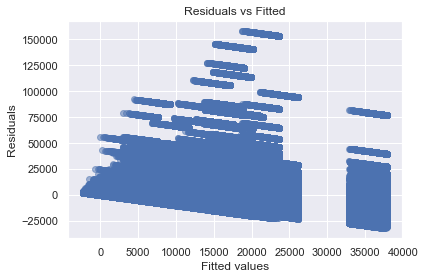

Durbin Watson Statistique : 0.001194587090934271
Test de Breusch-Pagan / Cook Weisberg : (311085.7820812004, 0.0, 106552.7282824923, 0.0)


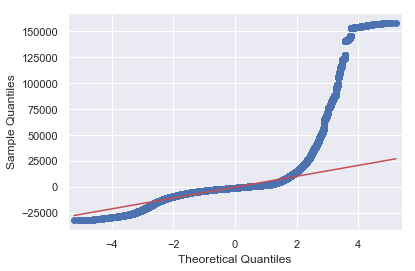

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro - Normalité des résidus  :   (0.579673171043396, 0.0) 

Kolmogorov-Smirnov :   Ks_2sampResult(statistic=0.24787189655172415, pvalue=3.3231470011633714e-54)

the statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt
4147257176.2187166 / 0.0 / 6.671711083910456 / 94.66507062987344
Test de Breusch-Pagan / Cook Weisberg : (311085.7820812004, 0.0, 106552.7282824923, 0.0)

Temps d'execution : 129.68164443969727 secondes ---


<Figure size 432x288 with 0 Axes>

In [48]:
#
#        REGRESSION avec les Variables explicatives :  - gdpppp
#                                                      - Gini
#                                                      - classe parent

# Décompte du temps que prend l'execution de cette cellule
start_time = time.time()

print("\n\nTemps d\'execution estimé pour cette cellule ->  xxx secondes\n")

regr = smf.ols('income~gdpppp+gini+classe_p', data=income3X).fit()   # LOIC

print(regr.summary())
print("\n\n")
print(sm.stats.anova_lm(regr, typ=3))

# Pour la décomposition de la variance
gdpppp   = sm.stats.anova_lm(regr, typ=3).sum_sq[1]
gini     = sm.stats.anova_lm(regr, typ=3).sum_sq[2]
classep  = sm.stats.anova_lm(regr, typ=3).sum_sq[3]
residual = sm.stats.anova_lm(regr, typ=3).sum_sq[4]
Total    = gdpppp + gini + classep + residual
var_gdpppp   = round((gdpppp/Total)*100,2)
var_gini     = round((gini/Total)*100,2)
var_classep  = round((classep/Total)*100,2)
var_residual = round((residual/Total)*100,2)
print("%Variance gdpppp   =", var_gdpppp,"%")
print("%Variance gini     =", var_gini,"%")
print("%Variance classe_p =", var_classep,"%")
print("%Variance residual =", var_residual,"%")


model_fitted_y = regr.fittedvalues                                       # model values
model_residuals = regr.resid                                             # model residuals
model_norm_residuals = regr.get_influence().resid_studentized_internal   # normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))     # absolute squared normalized residuals
model_abs_resid = np.abs(model_residuals)                                 # absolute residuals
model_leverage = regr.get_influence().hat_matrix_diag                    # leverage, from statsmodels internals
model_cooks = regr.get_influence().cooks_distance[0]                     # cook's distance, from statsmodels internals


# 1. Indépendance des résidus :   Residuals vs Fitted --- (Résidus vs Prédites)
#
plot_lm_1 = plt.figure()
plt.scatter(model_fitted_y, model_residuals, alpha=0.5);   
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
plot_lm_1.show()
plt.show()
plot_lm_1.savefig("Residuals vs Fitted")
# forme d'entonnoir (KO) 
#       => cela suggère que vos données souffrent d'hétéroscédasticité (les termes d'erreur ont une variance non constante).
# motif visible => data non linéaire


# Durbin Watson Statistique (DW) - Ce test mesure l'AUTOCORRELATION (résidus non indépendants => HETEROSCEDASTICITE)
dw = statsmodels.stats.stattools.durbin_watson(model_residuals)
print("Durbin Watson Statistique :", dw)   # = 0.0011905658707769826  - 0<DW<2 =>  autocorrélation positive
# Si dw=2 alors les résidus ne sont pas corrélés et sont indépendants.

# HETEROSCEDASTICITE :  Ceci peut être testé en utilisant le graphique "residual vs. fitted values ", 
#   (si une forme de cône est présente, une hétéroscédasticité est présente), 
#     ou en utilisant un test statistique tel que le test de Bruesch-Pagan :
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (310871.9095349927, 0.0, 106477.45566119968, 0.0)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité mais c'est plus faible
# On peut modifier le(s) variable(s) pour améliorer le modèle



# 2. Normalité des résidus :    Normal Q-Q ---
# 
#  nous confrontons la distribution empirique des résidus avec la distribution théorique de la loi normale
# L’inférence dans la régression linéaire multiple (MCO) repose sur l’hypothèse de normalité des erreurs. 
# L’hypothèse nulle (normalité) est rejetée si la série de points s’écarte manifestement de la diagonale
sm.qqplot(model_residuals, line='r')
plt.show()
plt.savefig("Normal Q-Q")   
# ligne courbée et déformée => les résidus ont une distribution non normale

print("Shapiro - Normalité des résidus  :  ",st.shapiro(model_residuals),"\n")
# Shapiro - Normalité des résidus  :   (0.5794929265975952, 0.0) => pas normale
# Si le test est significatif, la distribution ne suit pas une loi normale.  (p_value < 5%)
# Néanmoins l'observation des résidus et le fait qu'ils ne soient pas trés différents d'une distribution symétrique et 
# le fait qu'on ai une taille d'échantillon suffisante c.a.d supérieur à 30 nous permettent toutefois de penser que les résultats
# obtrenus par la regr. linéaire ne sont pas absurde même si les résidus n'est pas considérés comme Gaussien.

# Test de Kolmogorov-Smirnov     (adéquation à une loi normale)
# Le test étudie l'écart entre la fonction de répartition d'une loi normale et celle estimée de notre échantillon 
# Plus cette quantité est grande, plus on est enclin à rejeter l'hypothèse comme quoi l'échantillon est gaussien.
#  H0:  F=F0
print("Kolmogorov-Smirnov :  ",ks_2samp(model_residuals, list(np.random.normal(np.mean(model_residuals), np.std(model_residuals), 1000))))
# (statistic=0.23138732758620684, pvalue=2.7342284653237105e-47) => pas normale

# Jarque-Bera - Normalité des résidus
#   Ce test vérifie si l'asymétrie et le kurtosis observés correspondent à une distribution normale.
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(model_residuals)
print("\nthe statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt")
print(JB,"/",JBpv,"/",skw,"/",kurt)
# 4146154860.4184504 / 0.0 / 6.671232861909484 / 94.6527688821087
# Ici, on peut supposer que les erreurs suivent une distribution normale au niveau de 5%.
# On attend un skewness (mesure d'asymétrie)     proche de 0 => symétrie
# On attend un kurtosis (mesure d'aplatissement) proche de 0 => même aplatissement que la distribution normale
# On en est loin !



# 3. Homogénéité des variances :   Scale-Location ---
#
# plot_lm_3 = plt.figure()
# plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.8);
# sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
#               scatter=False, ci=False, lowess=True,
#              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
# plot_lm_3.axes[0].set_title('Scale-Location')
# plot_lm_3.axes[0].set_xlabel('Fitted values')
# plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# # annotations
# abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
# abs_norm_resid_top_3 = abs_norm_resid[:3]
# abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
# abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
# for i in abs_norm_resid_top_3:
#     plot_lm_3.axes[0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
# plot_lm_3.savefig("Scale-Location") 
# Ce graphique est également utile pour déterminer l'hétéroscédasticité. 
# Idéalement, ce graphique ne doit montrer aucun motif. La présence d'un motif détermine l'hétéroscédasticité. 
# Ce graphique corobbore la forme de l'entonnoir dans Residuals vs Fitted
# La ligne doit être +OU- horizontale

# Test de Breusch-Pagan / Cook Weisberg - Ce test determine la présence d'HETEROSCEDASTICITE
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (311700.4599774176, 0.0, 106769.08056041235, 0.0) => 0.0 < 5% => On rejette H0 (constance de la variance des résidus)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.


# 4. Residuals vs Leverage ---
#
# plot_lm_4 = plt.figure();
# plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
# sns.regplot(model_leverage, model_norm_residuals,
#               scatter=False, ci=False, lowess=True,
#               line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
# plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
# plot_lm_4.axes[0].set_ylim(-3, 5)
# plot_lm_4.axes[0].set_title('Residuals vs Leverage')
# plot_lm_4.axes[0].set_xlabel('Leverage')
# plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
# # annotations
# leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
# for i in leverage_top_3:
#     plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
# plot_lm_4.savefig("Residuals vs Leverage") 



print("\nTemps d\'execution : %s secondes ---" % (time.time() - start_time))



# L'ajustement du modèle est moyen, avec un R² = 0.472, est globalement significatif à 5% [F-statistic = 3.458e+06, avec
# Prob(F-statistic) = 0.00]. 
# Pour les paramètres estimés, seule la variable GDPPPP est pertinente pertinentes à 5%.
# Avertissement : peut être un problème de colinéarité entre les exogènes.
    
# On peut regarder les effets de chaque VI sur la VD (coef VI) et voir s’il s’agit ou non d’un prédicteur significatif (P>|z|).
# On veut une p_value <0,05. Tous les VI sont des prédicteurs significatifs des revenus. 
# Donc gini n'a pas d'importance dans ce contexte.

# Le coefficient (coef) peut être interprété comme étant l'effet d'un changement d'unité en termes de VD. 
# Ce qui signifie que pour chaque augmentation d'une unité de l'VI, la DV augmentera ou diminuera de la valeur du coefficient.

# Passons en revue l'équation de régression linéaire pour voir comment ces données constituent un modèle explicatif. 
# Explicatif lorsqu'il est utilisé pour expliquer l'influence de chaque VI.
#      income = -3157.3572 + 0.4847*(gdpppp) + 16.1552*(gini) + 51.1156(classe_p)

# Une analyse de régression multiple a été utilisée pour déterminer si le GDPPPP, l'indice de Gini et la classe_parent
#   prédisaient de manière significative l'income.
# Les résultats de la régression indiquent que les 4 prédicteurs expliquent 47,2% de la variance (R2 = 0,472).
# income = -3157.3572 + 0.4847*(gdpppp) + 16.1552*(gini) + 51.1156(classe_p)
# Toutes les variables indépendantes utilisées dans le modèle sont des prédicteurs significatifs de income. 
#  







Temps d'execution estimé pour cette cellule ->  19 secondes

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                 9.262e+06
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:08:27   Log-Likelihood:            -1.3115e+07
No. Observations:            11600000   AIC:                         2.623e+07
Df Residuals:                11599996   BIC:                         2.623e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


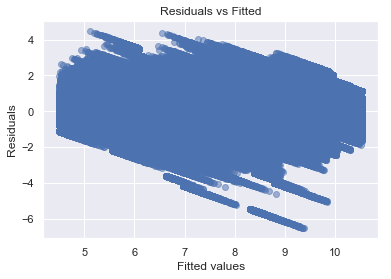

Durbin Watson Statistique : 0.002419763227937911
Test de Breusch-Pagan / Cook Weisberg : (385485.4975321218, 0.0, 132911.98736086124, 0.0)


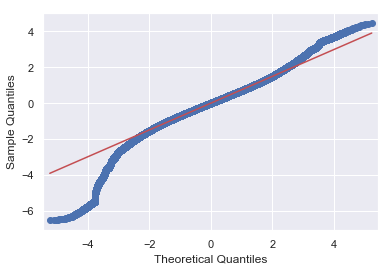

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro - Normalité des résidus  :   (1.000706434249878, 1.0) 

Kolmogorov-Smirnov :   Ks_2sampResult(statistic=0.028646810344827633, pvalue=0.3798970540983221)

the statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt
832318.6702668192 / 0.0 / -0.1175968966703052 / 4.291016075698634
Test de Breusch-Pagan / Cook Weisberg : (385485.4975321218, 0.0, 132911.98736086124, 0.0)

Temps d'execution : 131.22641253471375 secondes ---


<Figure size 432x288 with 0 Axes>

In [49]:
#
#        REGRESSION avec les Variables explicatives :  - log_gdpppp
#                                                      - Gini
#                                                      - classe parent

# Décompte du temps que prend l'execution de cette cellule
start_time = time.time()
print("\n\nTemps d\'execution estimé pour cette cellule ->  19 secondes\n")


regr = smf.ols('log_income~log_gdpppp+gini+classe_p', data=income3X).fit()   # LOIC

print(regr.summary())
print("\n\n")
print(sm.stats.anova_lm(regr, typ=3))

model_fitted_y = regr.fittedvalues                                       # model values
model_residuals = regr.resid                                             # model residuals
model_norm_residuals = regr.get_influence().resid_studentized_internal   # normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))     # absolute squared normalized residuals
model_abs_resid = np.abs(model_residuals)                                 # absolute residuals
model_leverage = regr.get_influence().hat_matrix_diag                    # leverage, from statsmodels internals
model_cooks = regr.get_influence().cooks_distance[0]                     # cook's distance, from statsmodels internals


# Pour la décomposition de la variance
log_gdpppp = sm.stats.anova_lm(regr, typ=3).sum_sq[1]
gini       = sm.stats.anova_lm(regr, typ=3).sum_sq[2]
classep    = sm.stats.anova_lm(regr, typ=3).sum_sq[3]
residual   = sm.stats.anova_lm(regr, typ=3).sum_sq[4]
Total    = log_gdpppp + gini + classep + residual
var_log_gdpppp  = round((log_gdpppp/Total)*100,2)
var_gini        = round((gini/Total)*100,2)
var_classep     = round((classep/Total)*100,2)
var_residual    = round((residual/Total)*100,2)
print("%Variance log_gdpppp =", var_log_gdpppp,"%")
print("%Variance gini       =", var_gini,"%")
print("%Variance classe_p   =", var_classep,"%")
print("%Variance residual   =", var_residual,"%")


# 1. Indépendance des résidus :   Residuals vs Fitted --- (Résidus vs Prédites)
#
plot_lm_1 = plt.figure()
plt.scatter(model_fitted_y, model_residuals, alpha=0.5);   
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');
plot_lm_1.show()
plt.show()
plot_lm_1.savefig("Residuals vs Fitted")
# forme d'entonnoir (KO) 
#       => cela suggère que vos données souffrent d'hétéroscédasticité (les termes d'erreur ont une variance non constante).
# motif visible => data non linéaire



# Durbin Watson Statistique (DW) - Ce test mesure l'AUTOCORRELATION (résidus non indépendants => HETEROSCEDASTICITE)
dw = statsmodels.stats.stattools.durbin_watson(model_residuals)
print("Durbin Watson Statistique :", dw)   # = 0.0024160856818489108  - 0<DW<2 =>  autocorrélation positive
# Si dw=2 alors les résidus ne sont pas corrélés et sont indépendants.

# HETEROSCEDASTICITE :  Ceci peut être testé en utilisant le graphique "residual vs. fitted values ", 
#   (si une forme de cône est présente, une hétéroscédasticité est présente), 
#     ou en utilisant un test statistique tel que le test de Bruesch-Pagan :
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (387360.6229664026, 0.0, 133580.84942876748, 0.0)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.
# On peut modifier le(s) variable(s) pour améliorer le modèle

# 2. Normalité des résidus :    Normal Q-Q ---
# 
#  nous confrontons la distribution empirique des résidus avec la distribution théorique de la loi normale
# L’inférence dans la régression linéaire multiple (MCO) repose sur l’hypothèse de normalité des erreurs. 
# L’hypothèse nulle (normalité) est rejetée si la série de points s’écarte manifestement de la diagonale
sm.qqplot(model_residuals, line='r')
plt.show()
plt.savefig("Normal Q-Q")   
# ligne courbée et déformée => les résidus ont une distribution non normale

print("Shapiro - Normalité des résidus  :  ",st.shapiro(model_residuals),"\n")
# Shapiro - Normalité des résidus  :   (0.9997796416282654, 2.5387021072057186e-24) => pas normale
# Si le test est significatif, la distribution ne suit pas une loi normale.  (p_value < 5%)

# Test de Kolmogorov-Smirnov     (adéquation à une loi normale)
# Le test étudie l'écart entre la fonction de répartition d'une loi normale et celle estimée de notre échantillon 
# Plus cette quantité est grande, plus on est enclin à rejeter l'hypothèse comme quoi l'échantillon est gaussien.
#  H0:  F=F0
print("Kolmogorov-Smirnov :  ",ks_2samp(model_residuals, list(np.random.normal(np.mean(model_residuals), np.std(model_residuals), 1000))))
# (statistic=0.04424060344827585, pvalue=0.038711719464839686) => pas normale mais presque

# Jarque-Bera - Normalité des résidus
#   Ce test vérifie si l'asymétrie et le kurtosis observés correspondent à une distribution normale.
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(model_residuals)
print("\nthe statistic JB / the p-value of the test JBpv / the skewness skw / the kurtosis kurt")
print(JB,"/",JBpv,"/",skw,"/",kurt)
# 827993.5181600912 / 0.0 / -0.11652789489376181 / 4.287934406877585
# Ici, on peut supposer que les erreurs suivent une distribution normale au niveau de 5%.
# On attend un skewness (mesure d'asymétrie)     proche de 0 => symétrie
# On attend un kurtosis (mesure d'aplatissement) proche de 0 => même aplatissement que la distribution normale
# On en est loin !




# 3. Homogénéité des variances :   Scale-Location ---
#
# plot_lm_3 = plt.figure()
# plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.8);
# sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
#               scatter=False, ci=False, lowess=True,
#              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
# plot_lm_3.axes[0].set_title('Scale-Location')
# plot_lm_3.axes[0].set_xlabel('Fitted values')
# plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# # annotations
# abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
# abs_norm_resid_top_3 = abs_norm_resid[:3]
# abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
# abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
# for i in abs_norm_resid_top_3:
#     plot_lm_3.axes[0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
# plot_lm_3.savefig("Scale-Location") 
# Ce graphique est également utile pour déterminer l'hétéroscédasticité. 
# Idéalement, ce graphique ne doit montrer aucun motif. La présence d'un motif détermine l'hétéroscédasticité. 
# Ce graphique corobbore la forme de l'entonnoir dans Residuals vs Fitted
# La ligne doit être +OU- horizontale

# Test de Breusch-Pagan / Cook Weisberg - Ce test determine la présence d'HETEROSCEDASTICITE
test = sms.het_breuschpagan(regr.resid, regr.model.exog)
print("Test de Breusch-Pagan / Cook Weisberg :", test)
# (387360.6229664026, 0.0, 133580.84942876748, 0.0)
# Le test est significatif, c'est-à-dire que les données violent l'hypothèse d'homoscédasticité.


# 4. Residuals vs Leverage ---
#
# plot_lm_4 = plt.figure();
# plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
# sns.regplot(model_leverage, model_norm_residuals,
#               scatter=False, ci=False, lowess=True,
#               line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
# plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
# plot_lm_4.axes[0].set_ylim(-3, 5)
# plot_lm_4.axes[0].set_title('Residuals vs Leverage')
# plot_lm_4.axes[0].set_xlabel('Leverage')
# plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
# # annotations
# leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
# for i in leverage_top_3:
#     plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
# plot_lm_4.savefig("Residuals vs Leverage") 



print("\nTemps d\'execution : %s secondes ---" % (time.time() - start_time))



# L'ajustement du modèle est moyen, avec un R² = 0.705, est globalement significatif à 5% [F-statistic = 9.257e+06, avec
# Prob(F-statistic) = 0.00]. 
# Pour les paramètres estimés, toutes les variables sont pertinentes à 5%.
# Avertissement : 
    
# On peut regarder les effets de chaque VI sur la VD (coef VI) et voir s’il s’agit ou non d’un prédicteur significatif (P>|z|).
# On veut une p_value <0,05. Tous les VI sont des prédicteurs significatifs des revenus. 
# Donc gini n'a pas d'importance dans ce contexte.

# Le coefficient (coef) peut être interprété comme étant l'effet d'un changement d'unité en termes de VD. 
# Ce qui signifie que pour chaque augmentation d'une unité de l'VI, la DV augmentera ou diminuera de la valeur du coefficient.

# Passons en revue l'équation de régression linéaire pour voir comment ces données constituent un modèle explicatif. 
# Explicatif lorsqu'il est utilisé pour expliquer l'influence de chaque VI.
#      log_income = 0.3550 + 0.8639*(log_gdpppp) + -0.0176*(gini) + 0.0109(classe_p)

# Une analyse de régression multiple a été utilisée pour déterminer si le LOG_GDPPPP, l'indice de Gini et la classe_parent 
#  prédisaient de manière significative l'income.
# Les résultats de la régression indiquent que les 4 prédicteurs expliquent 70,5% de la variance (R2 = 0,705).
# log_income = 0.3550 + 0.8639*(log_gdpppp) + -0.0176*(gini) + 0.0109(classe_p)
# Toutes les variables indépendantes utilisées dans le modèle sont des prédicteurs significatifs de income. 
#  



In [ ]:
# LOIC

   VARIABLE       VARIABLES                           R2   -   F-stat            
   expliquée      explicatives                                                   
   --------------------------------------------------------------------
    
   income         pays                               49.6%    98
   log(income)    pays                               72.9%    269

1. income         gdpppp + Gini                      44.8%    4699   
2. log(income)    log_gdpppp + Gini                  65.3%    1.092e+04
 
3. income         gdpppp + Gini + classe_parent      47.2%    3.458e+06                           
4. log(income)    log(gdpppp) + Gini + classe_p      70.5%    9.245e+06

   --------------------------------------------------------------------

1. income      =  -576.0182   +0.4847*(gdpppp)
2. log(income) =   0.9069     +0.8639*(log(gdpppp)  -0.0176*(gini)
3. income      =  -3151.1102  + 0.4847*(gdpppp)     +16.1552*(gini)  +50.9919*(classe_p)                                                          
4. log(income) =   0.3555     +0.8639*(log(gdpppp)  -0.0176*(gini)   +0.0109*(classe_p)
        
   --------------------------------------------------------------------                                       
                                       

  "Test de Breusch-Pagan / Cook Weisberg" - HOMOSCEDASTICITE                                      
1.  (289.49596312989405, 1.3700939219771155e-63, 148.41445940310282, 2.2671968362858244e-64)                                       
2.  (566.5935814605449, 9.242022999125912e-124, 297.76777519756007, 7.799322040841137e-127)                                       
3.  (311700.4599774176, 0.0, 106769.08056041235, 0.0)   => mieux                                    
4.  (387360.6229664026, 0.0, 133580.84942876748, 0.0)   => mieux

  "Test de Kolmogorov-Smirnov" - NORMALITE des RESIDUS
1. (statistic=0.23241379310344823, pvalue=5.67702183339604e-44)   => pas normale                                   
2. (statistic=0.04143103448275853, pvalue=0.08263458594647881)    => normale                                     
3. (statistic=0.23138732758620684, pvalue=2.7342284653237105e-47) => pas normale                                      
4. (statistic=0.04424060344827585, pvalue=0.038711719464839686)   => pas normale mais presque
                  
                                       
                                       


In [ ]:
# --- gini / Revenu moyen (mean)
fig = plt.figure(figsize = (13, 8))
plt.scatter(income2X['gini'], income2X['gdpppp'])
plt.xlabel("Indice Gini")
plt.ylabel("Revenus moyen (mean)") 
plt.show()
# Le revenu moyen baisse lorsque gini croit 
#  <=> Le revenu moyen baisse lorsque les revenus sont plus mal réparties

# --- gini / revenu
fig = plt.figure(figsize = (13, 8))
# plt.scatter(income2X['gini'], income2X['income'])
plt.scatter(income2X['gini'], income2X['log_income'])
plt.xlabel("Indice Gini")
plt.ylabel("Revenus")
plt.show()

# Grand Coef d'élasticité => Grand Gini => Petit income moyen  ???
# Coef elasticité = 0.1  : forte mobilité intergénérationnelle
# Coef elasticité = 0.9  : faible mobilité intergénérationnelle

# --- gini / ige
fig = plt.figure(figsize = (13, 8))
plt.scatter(income2X['gini'], income2X['ige'])
plt.xlabel("Indice Gini")
plt.ylabel("Ige") 
plt.show()
# ige croit lorsque gini croit <=> La mobilité intergénérationnelle diminue lorsque les revenus sont plus mal réparties
